# Archaic admixture in swept and non-swept haplotypes and regions

In [74]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

Plotting setup:

In [75]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}


def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [76]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [77]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [78]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [79]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [80]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

## Load meta data

In [81]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

## Sweep and admixture data

In [82]:
admix_windows_chrX = pandas.read_hdf(results_dir / 'male_x_admix_windows.hdf')
admix_windows_chrX.head()

chrom            name   start     end  nr_admix_tracts  tot_admix_len  \
0     X  B_Australian-4       0  100000                0              0   
1     X  B_Australian-4  100000  200000                0              0   
2     X  B_Australian-4  200000  300000                0              0   
3     X  B_Australian-4  300000  400000                0              0   
4     X  B_Australian-4  400000  500000                0              0   

   archaic_snps  altai_snps  denisova_snps  vindija_snps  mean_post_prob  \
0           NaN         NaN            NaN           NaN             NaN   
1           NaN         NaN            NaN           NaN             NaN   
2           NaN         NaN            NaN           NaN             NaN   
3           0.0         0.0            0.0           0.0             NaN   
4           0.0         0.0            0.0           0.0             NaN   

   admix_prop  level_1  bases_analyzed  
0         NaN        0            1337  
1         NaN        1            5045  
2         NaN        2            9875  
3         0.0        3           26649  
4         0.0        4           22968

In [83]:
admix_windows_chrX_full = pandas.read_hdf(results_dir / 'male_x_admix_windows_full.hdf')
admix_windows_chrX_full.head()

chrom            name   start     end  nr_admix_tracts  tot_admix_len  \
0     X  B_Australian-4       0  100000                0              0   
1     X  B_Australian-4  100000  200000                0              0   
2     X  B_Australian-4  200000  300000                0              0   
3     X  B_Australian-4  300000  400000                0              0   
4     X  B_Australian-4  400000  500000                0              0   

   mean_post_prob  admix_prop  level_1  bases_analyzed  
0             NaN         NaN        0            1602  
1             NaN         NaN        1            6492  
2             NaN         NaN        2           14598  
3             NaN         0.0        3           37371  
4             NaN         0.0        4           31532

In [84]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

# analysis without repeats
merged_data = (sweep_data.merge(admix_windows_chrX, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

# analysis including repeats
merged_data_full = (sweep_data.merge(admix_windows_chrX_full, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

In [85]:
df = merged_data[['name', 'start', 'admix_prop']].merge(merged_data_full[['name', 'start', 'admix_prop']], 
                                                   on=['name', 'start'], how='outer')

In [86]:
((~df.admix_prop_x.isnull() & ~df.admix_prop_y.isnull()).sum(), 
 (df.admix_prop_x.isnull() & ~df.admix_prop_y.isnull()).sum())

(169377, 23766)

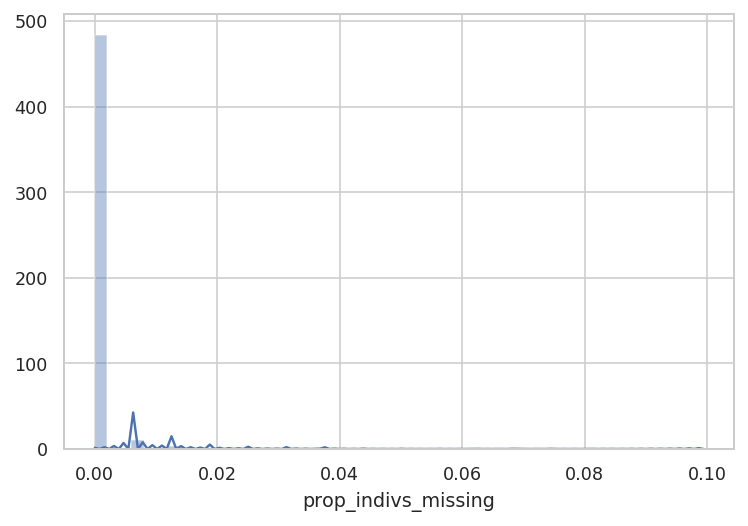

In [87]:
g = sns.distplot(merged_data.prop_indivs_missing)

## Global admixture proportions

In [88]:
merged_data.loc[lambda df: df.region_1 != 'Africa', 'admix_prop'].mean()

0.008050443684797818

In [89]:
merged_data.groupby('region_1')['admix_prop'].mean()

region_1
Africa                     NaN
WestEurasia           0.006498
SouthAsia             0.008298
CentralAsiaSiberia    0.004931
Oceania               0.014618
EastAsia              0.008455
America               0.005812
Name: admix_prop, dtype: float64

In [90]:
merged_data.head()

indiv_1    start      end       pop_1 region_label_1  region_id_1  \
27  B_Australian-4  2700000  2800000  Australian        Oceania            4   
28  B_Australian-4  2800000  2900000  Australian        Oceania            4   
29  B_Australian-4  2900000  3000000  Australian        Oceania            4   
30  B_Australian-4  3000000  3100000  Australian        Oceania            4   
31  B_Australian-4  3100000  3200000  Australian        Oceania            4   

   region_1  mean_dist  mean_dist_af  mean_dist_to_africans       ...        \
27  Oceania   0.001051      0.001051               0.001735       ...         
28  Oceania   0.000633      0.000623               0.001109       ...         
29  Oceania   0.000377      0.000318               0.000844       ...         
30  Oceania   0.001087      0.001087               0.001078       ...         
31  Oceania   0.001212      0.001205               0.001544       ...         

    nr_admix_tracts  tot_admix_len  archaic_snps  altai_snps  denisova_snps  \
27              0.0            0.0           0.0         0.0            0.0   
28              0.0            0.0           0.0         0.0            0.0   
29              0.0            0.0           0.0         0.0            0.0   
30              0.0            0.0           0.0         0.0            0.0   
31              0.0            0.0           0.0         0.0            0.0   

    vindija_snps  mean_post_prob  admix_prop  level_1  bases_analyzed  
27           0.0             NaN         0.0     27.0         31236.0  
28           0.0             NaN         0.0     28.0         27918.0  
29           0.0             NaN         0.0     29.0         31151.0  
30           0.0             NaN         0.0     30.0         41200.0  
31           0.0             NaN         0.0     31.0         45155.0  

[5 rows x 47 columns]

## Admixture segments across the X chromosome

In [91]:
extended_peak_regions_10 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')


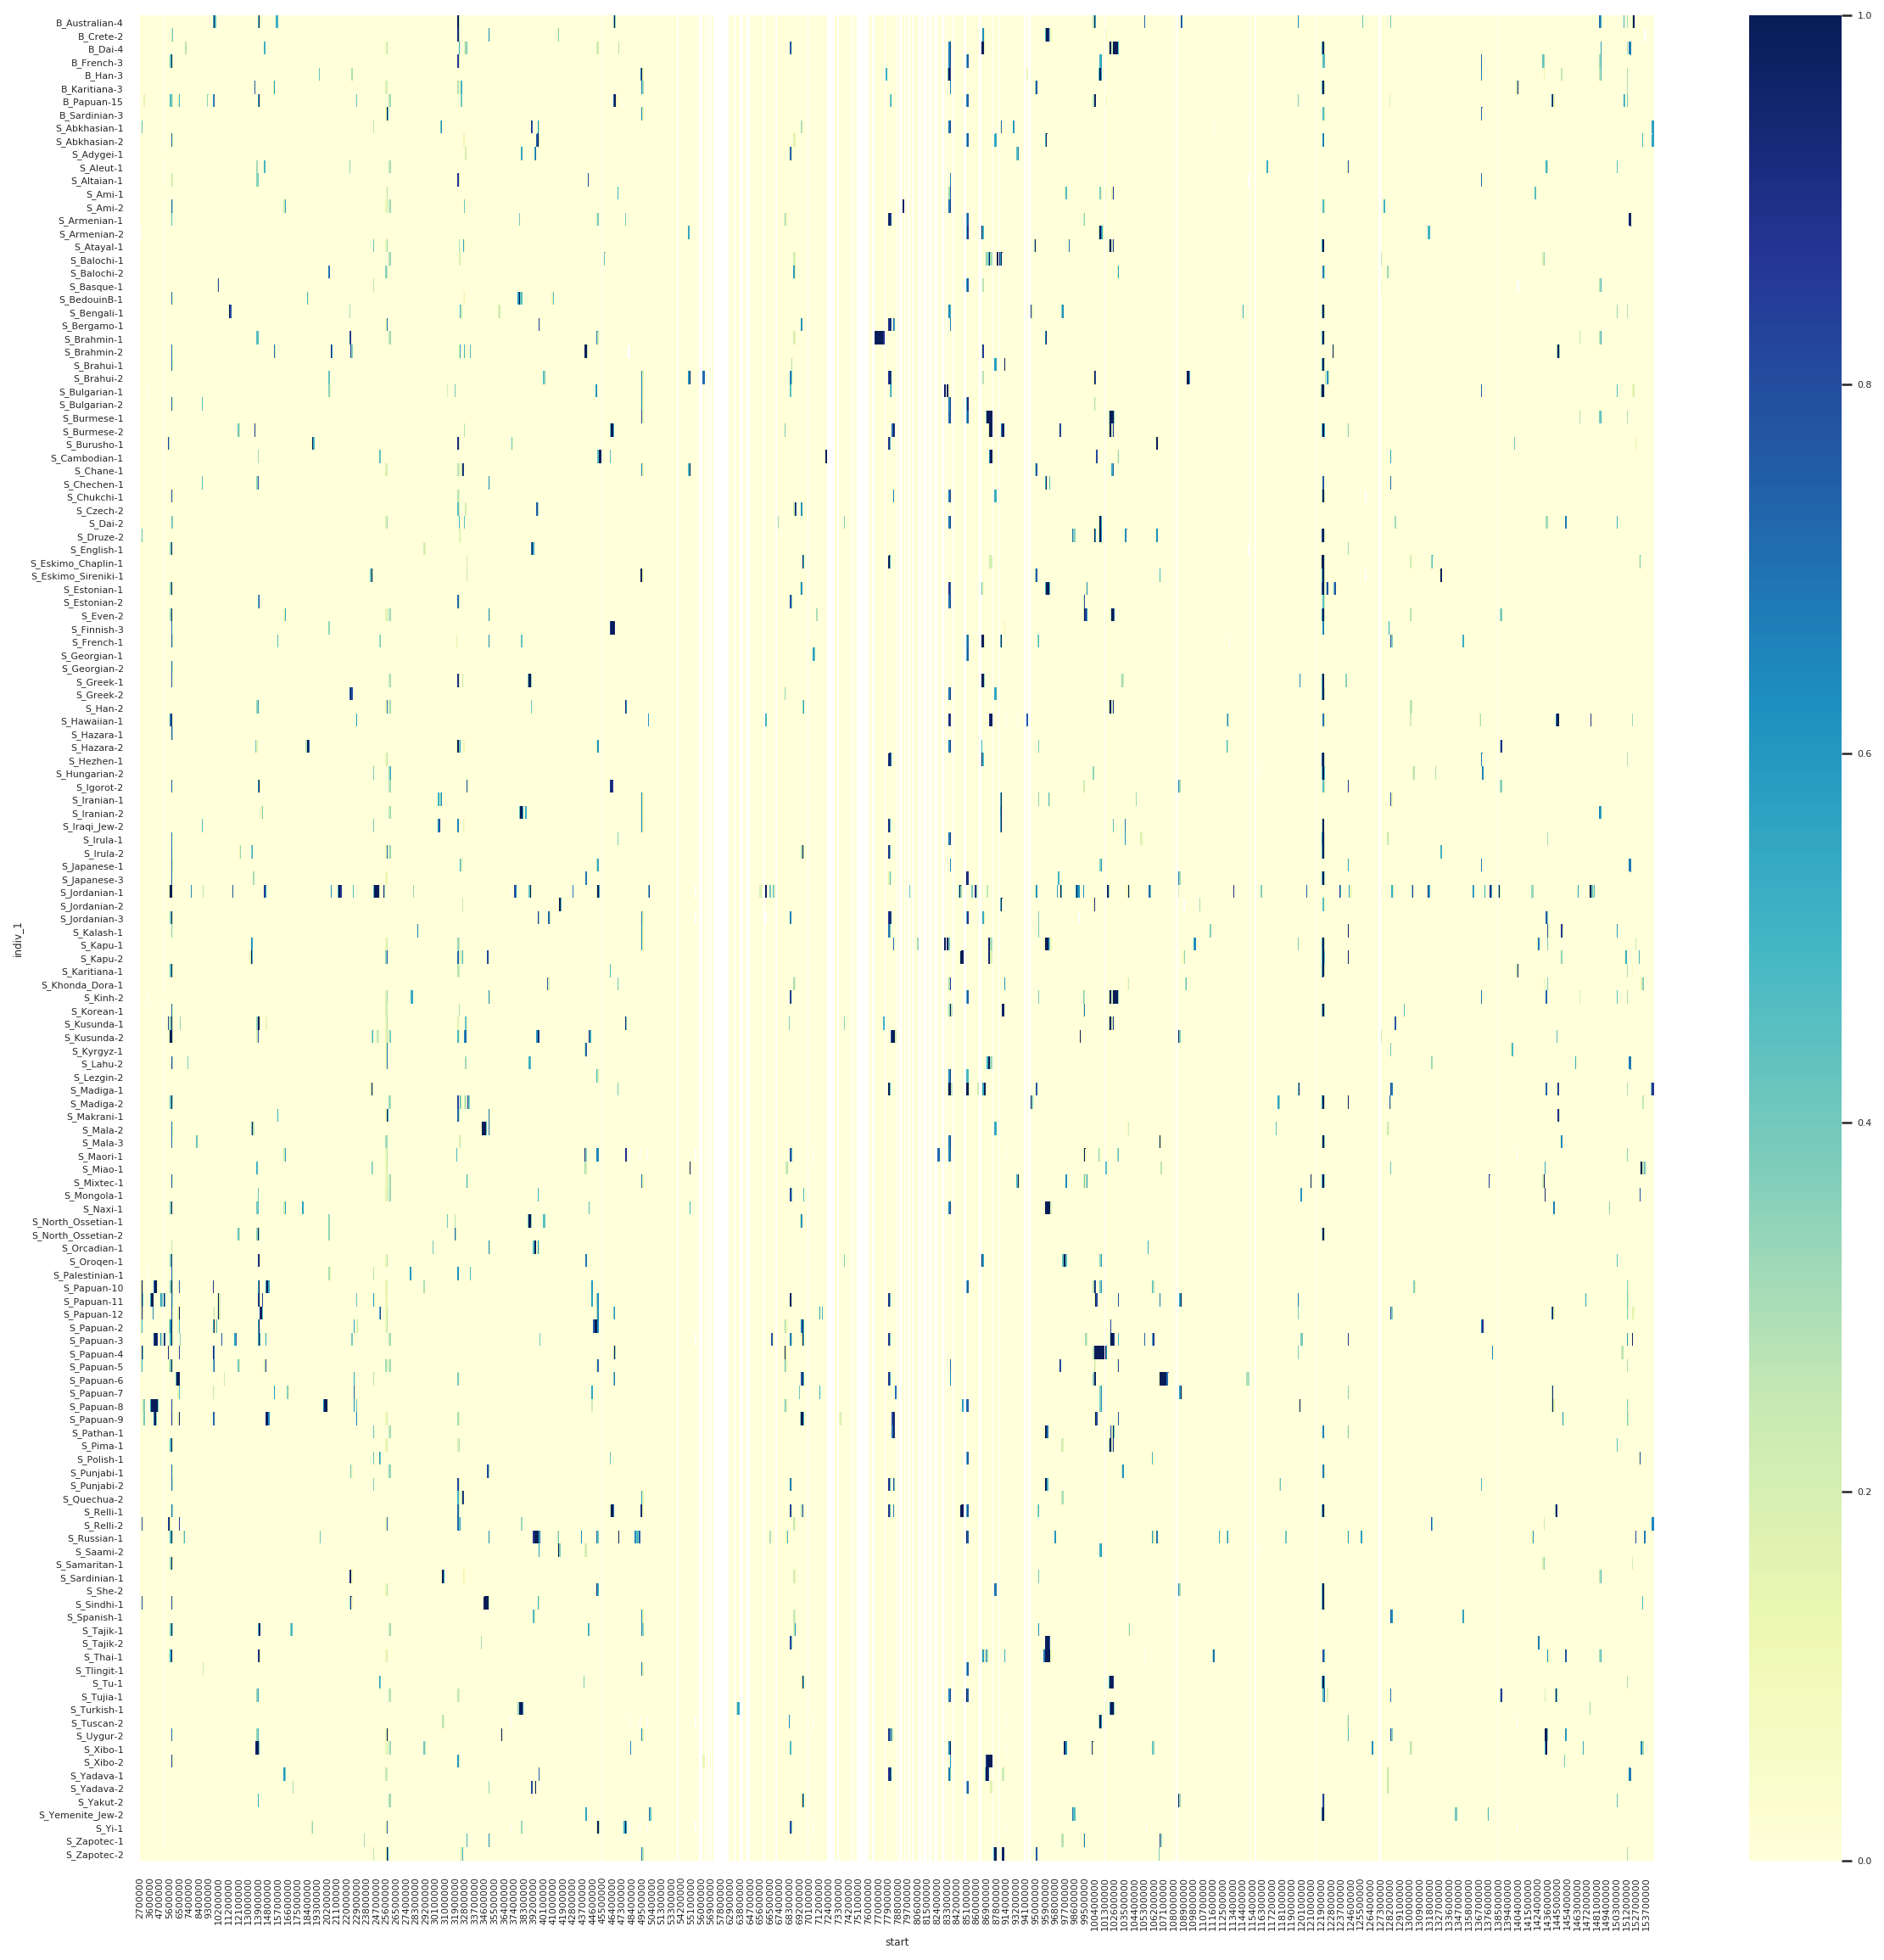

In [92]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(merged_data.loc[merged_data.region_1 != 'Africa'].pivot('indiv_1', 'start', 'admix_prop'), cmap="YlGnBu")

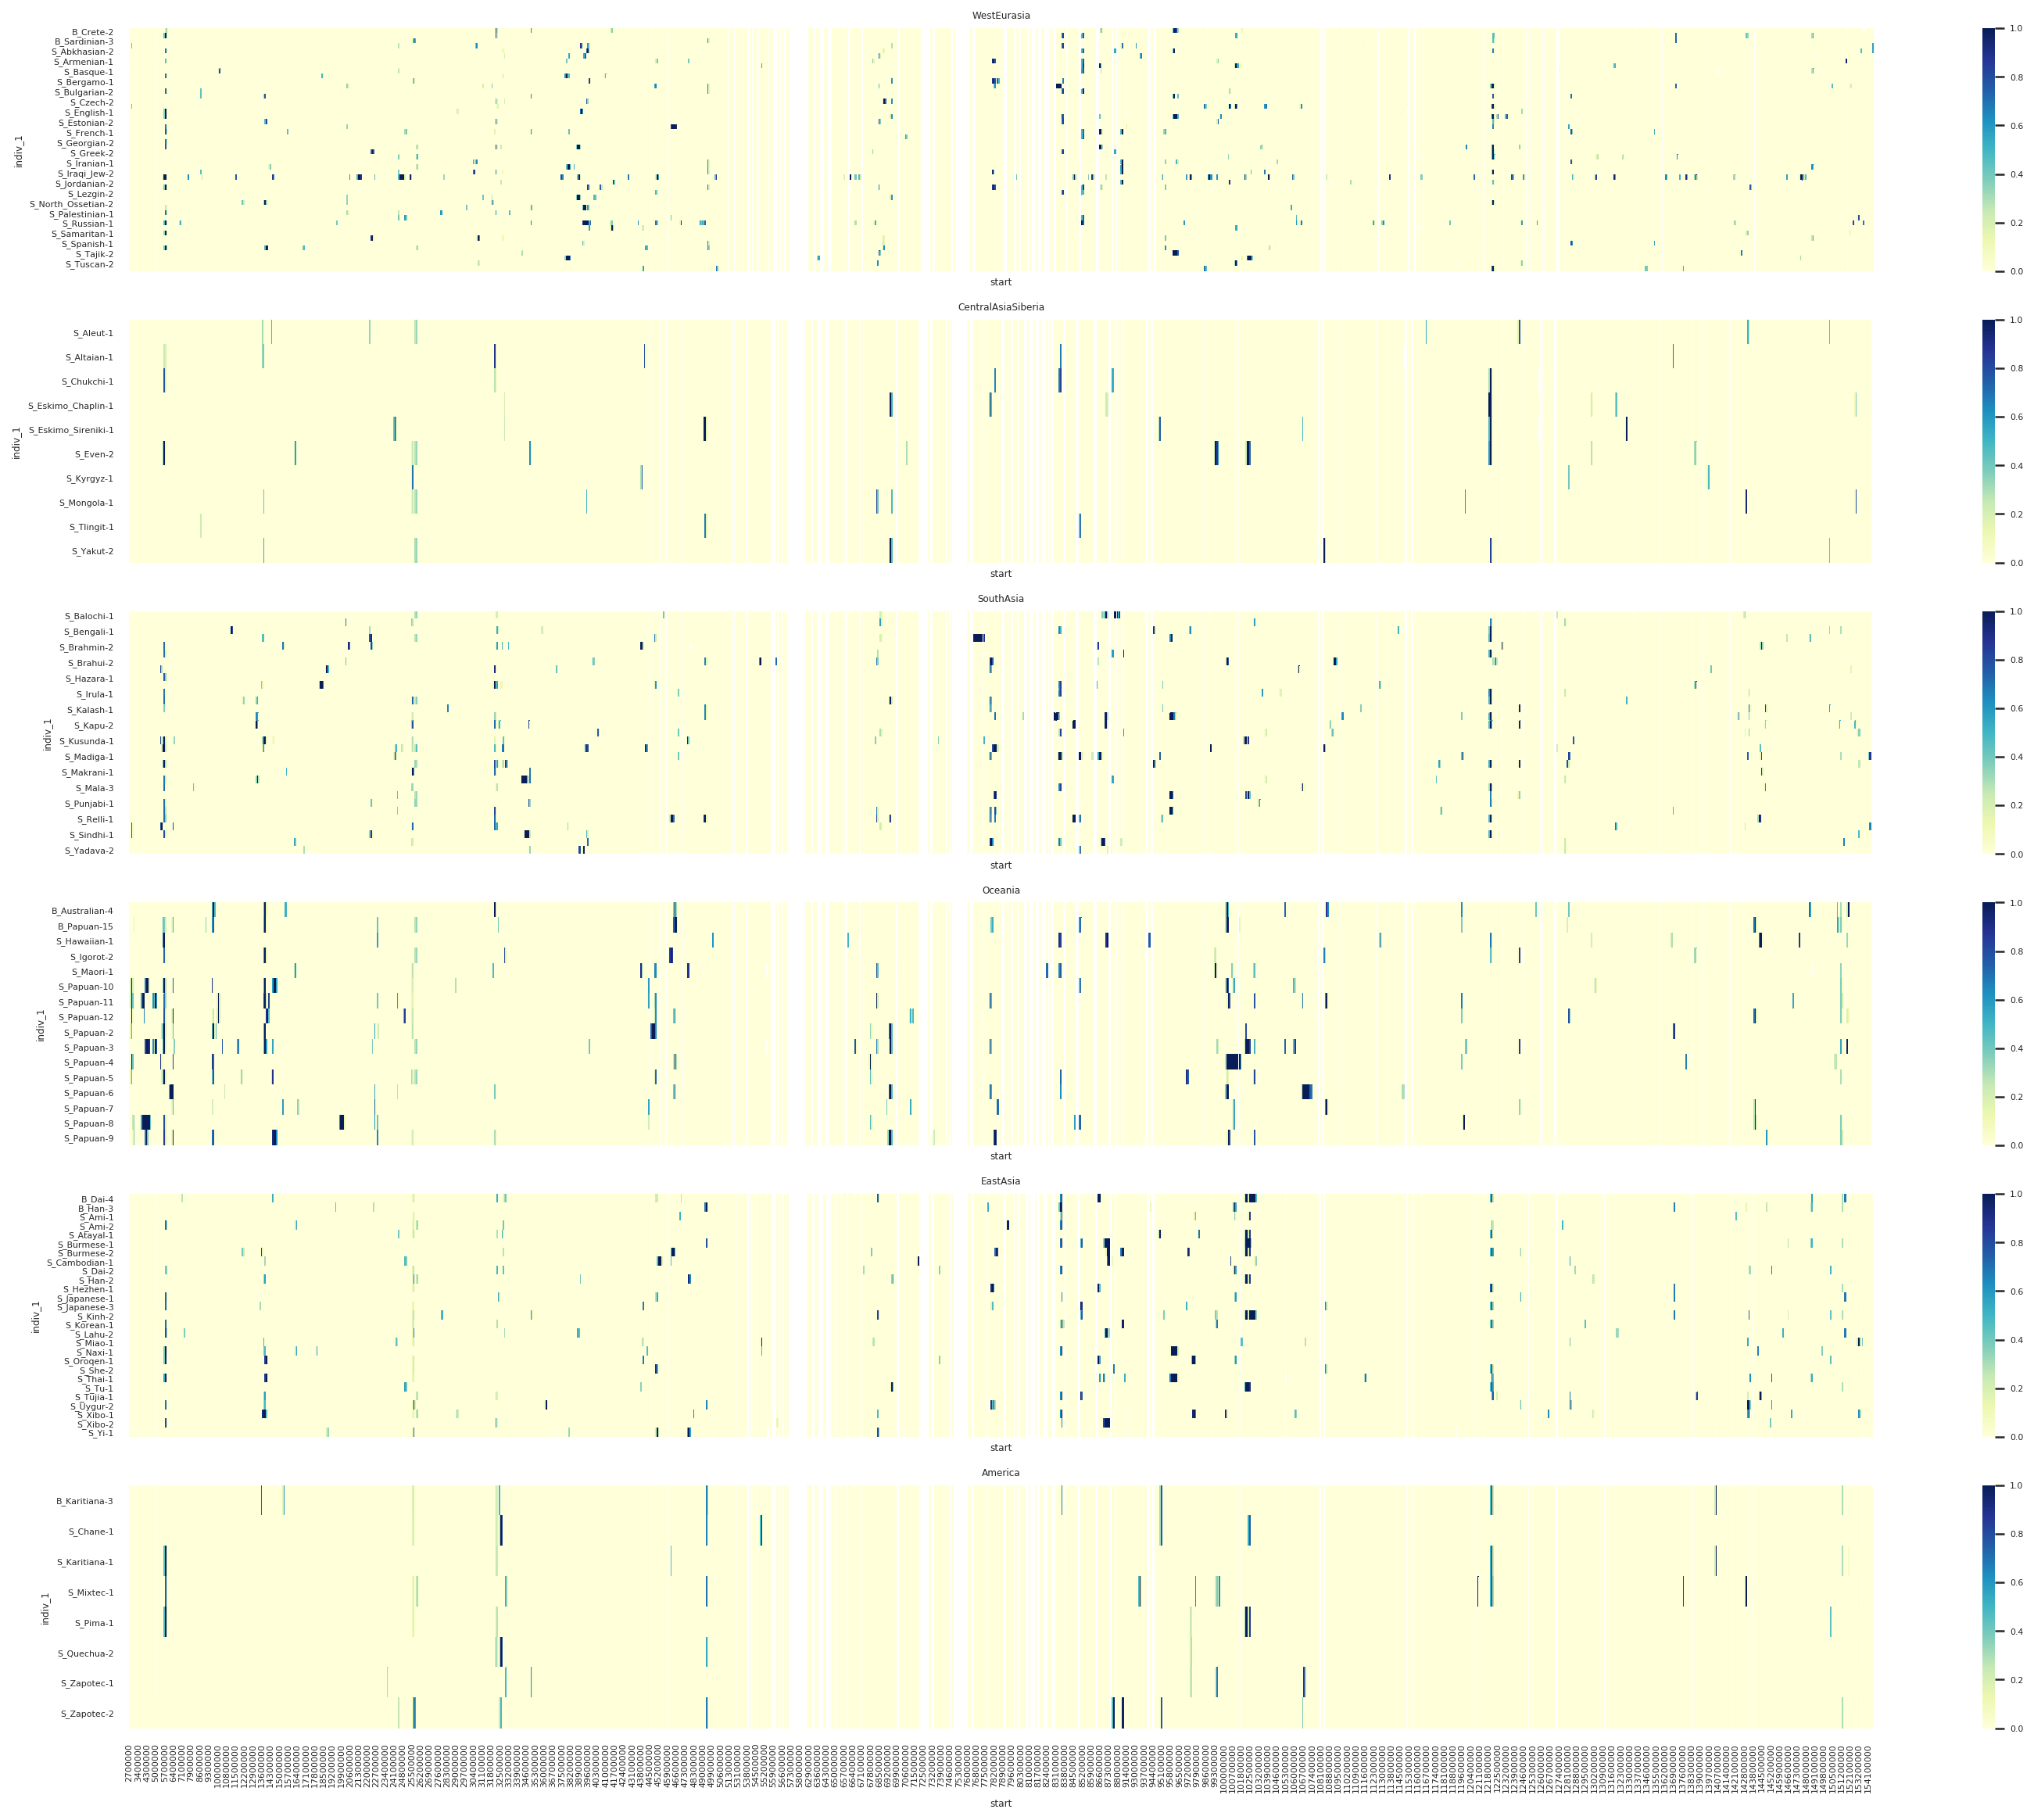

In [93]:
with sns.plotting_context('notebook', font_scale=0.5):
    fig, axes = plt.subplots(6, 1, figsize=(25,20), sharex=True)
    for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
        df = merged_data.loc[merged_data.region_label_1 == region]
        table = df.pivot('indiv_1', 'start', 'admix_prop')
        ax = sns.heatmap(table, ax=axes[i], cmap="YlGnBu")
        axes[i].set_title(region)

## Admixture proportions in stratified by `never_swept`

In [94]:
merged_data.groupby('never_swept')['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept                  
False        0.004029   35963
True         0.009134  133414

In [95]:
merged_data.groupby('never_swept_af')['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept_af                  
False           0.004879   36523
True            0.008922  132854

In [96]:
merged_data.groupby(['never_swept', 'never_swept_af'])['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept never_swept_af                  
False       False           0.004029   35963
True        False           0.059482     560
            True            0.008922  132854

Test difference between `never_swept` `True` and `False`:

In [97]:
scipy.stats.ttest_ind(merged_data.loc[merged_data.never_swept == True, 'admix_prop'],
                      merged_data.loc[merged_data.never_swept == False, 'admix_prop'],
                      nan_policy='omit'
                     )

Ttest_indResult(statistic=11.49361076407204, pvalue=1.4580903295039345e-30)

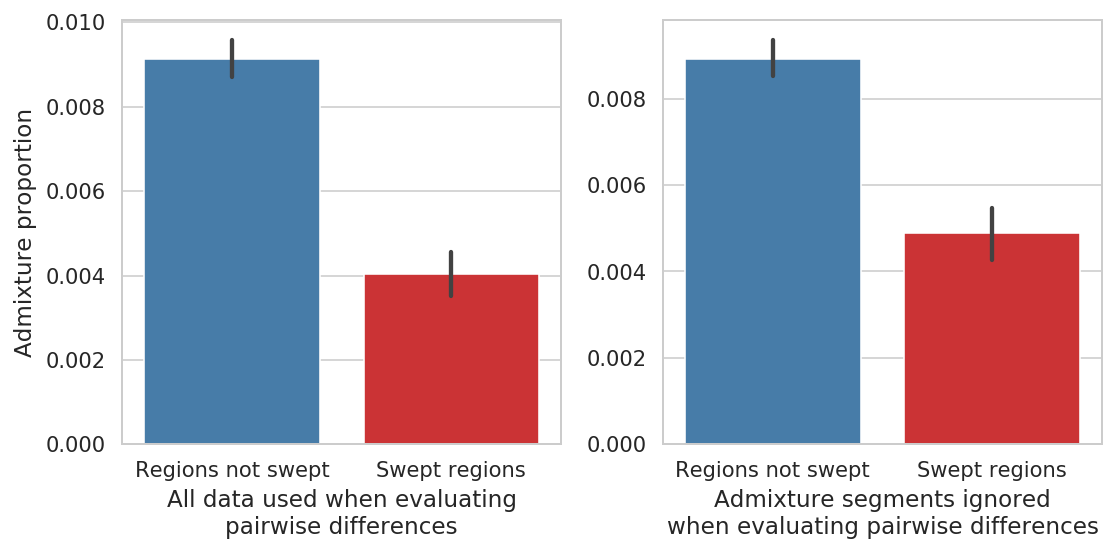

In [98]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            g1 = sns.barplot(x="not_never_swept", y="admix_prop", 
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), 
                             ax=ax1, n_boot=1000)
            g2 = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g1.set_ylabel("Admixture proportion")
            g2.set_ylabel("")
            g1.set_xlabel("All data used when evaluating\npairwise differences")
            g2.set_xlabel("Admixture segments ignored\nwhen evaluating pairwise differences")
            
            g1.set_xticklabels(['Regions not swept', 'Swept regions'])
            g2.set_xticklabels(['Regions not swept', 'Swept regions'])

            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.pdf'))
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.png'))



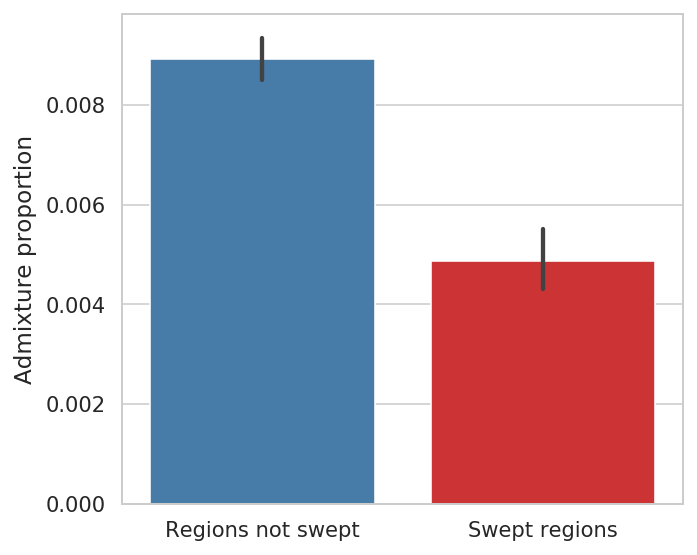

In [99]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, ax2 = plt.subplots(1, figsize=(5,4))
            g = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g.set_ylabel("Admixture proportion")
            g.set_xlabel('')
            g.set_xticklabels(['Regions not swept', 'Swept regions'])
                        
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions_af.pdf'))


## Admixture proportions only in windows that are `swept` in some males and not in others

In [100]:
df = (merged_data.loc[lambda df: (df.partial_sweep_win == True),# & (df.conserv_swept_group != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept', 'admix_prop']]
      
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
      
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept'], 
                 var_name='call',
                value_name='is_swept')
          )

df_af = (merged_data.loc[lambda df: (df.partial_sweep_win_af == True),# & (df.conserv_swept_group_af != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept_af', 'admix_prop']]
         
         
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
         
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept_af'], 
                 var_name='call',
                value_name='is_swept')
          )

plot_df = pandas.concat([df, df_af])
plot_df['region_1'] = plot_df.region_1.astype('category').cat.set_categories(
    ['Africa', 'WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'Oceania', 'EastAsia', 'America'])

plot_df = plot_df.loc[lambda df: df.region_1 != 'Africa']


# plot_df['region_1'] 
plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

plot_df.head()

indiv_1 region_1     start  admix_prop   call  is_swept
0  B_Australian-4  Oceania  11100000         0.0  swept      True
1  B_Australian-4  Oceania  11200000         0.0  swept      True
2  B_Australian-4  Oceania  11300000         0.0  swept      True
3  B_Australian-4  Oceania  11400000         0.0  swept      True
4  B_Australian-4  Oceania  11500000         0.0  swept      True

In [101]:
df = plot_df.groupby(['call', 'is_swept'])['admix_prop'].agg(['mean', 'sem'])
df

mean       sem
call     is_swept                    
swept    False     0.008102  0.000577
         True      0.000126  0.000048
swept_af False     0.007932  0.000564
         True      0.001946  0.000297

Reduction in admixture proportion in ECHs compared to ECHs in the same windows

In [102]:
(df.loc[('swept', False), 'mean'] - df.loc[('swept', True), 'mean']) / df.loc[('swept', False), 'mean']

0.9844086439508413

Plots are based on this many 100kb windows along the chromosome:

In [103]:
plot_df.start.drop_duplicates().size

302

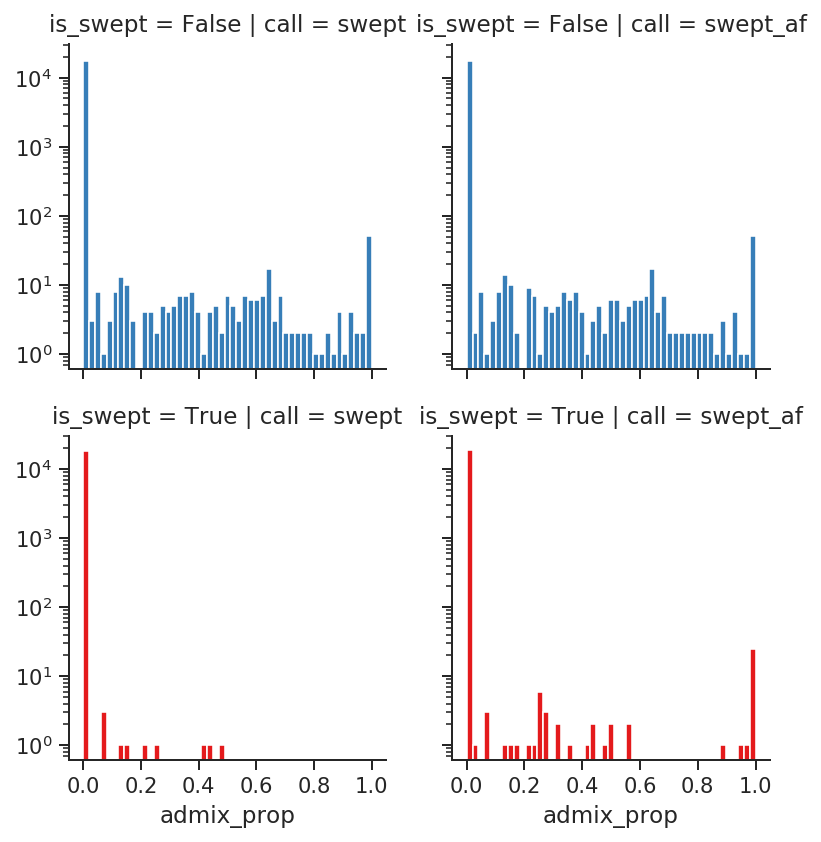

In [104]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.FacetGrid(row='is_swept', col='call', hue='is_swept', data=plot_df, sharex=True, sharey=True)
            g.map(plt.hist, 'admix_prop', bins=numpy.linspace(0, 1, 50))
            
#             g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
#             g.set_ylabel('Mean admixture proportion')
#             g.set_xlabel('')
#             g.set_xticklabels(['All data used when evaluating\npairwise differences', 
#                                'Admixture segments ignored\nwhen evaluating pairwise distances'])
            
            [ax.set_yscale('log') for ax in g.axes.flat]

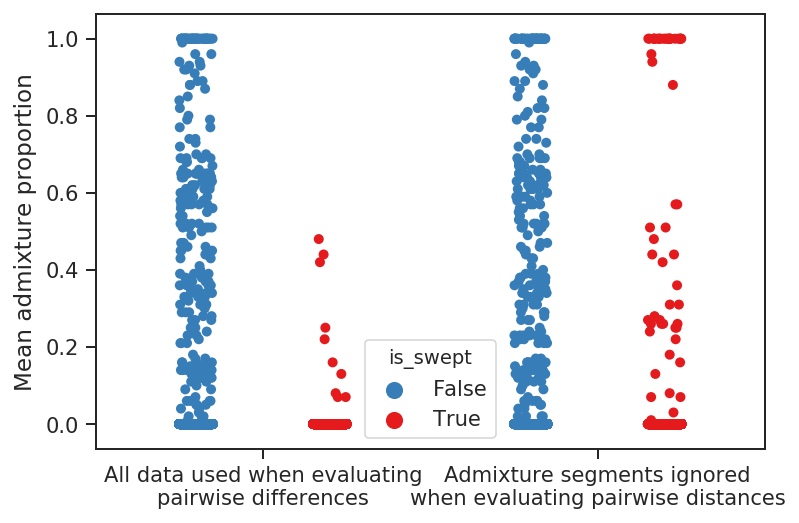

In [105]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
#            g.set_yscale('log')

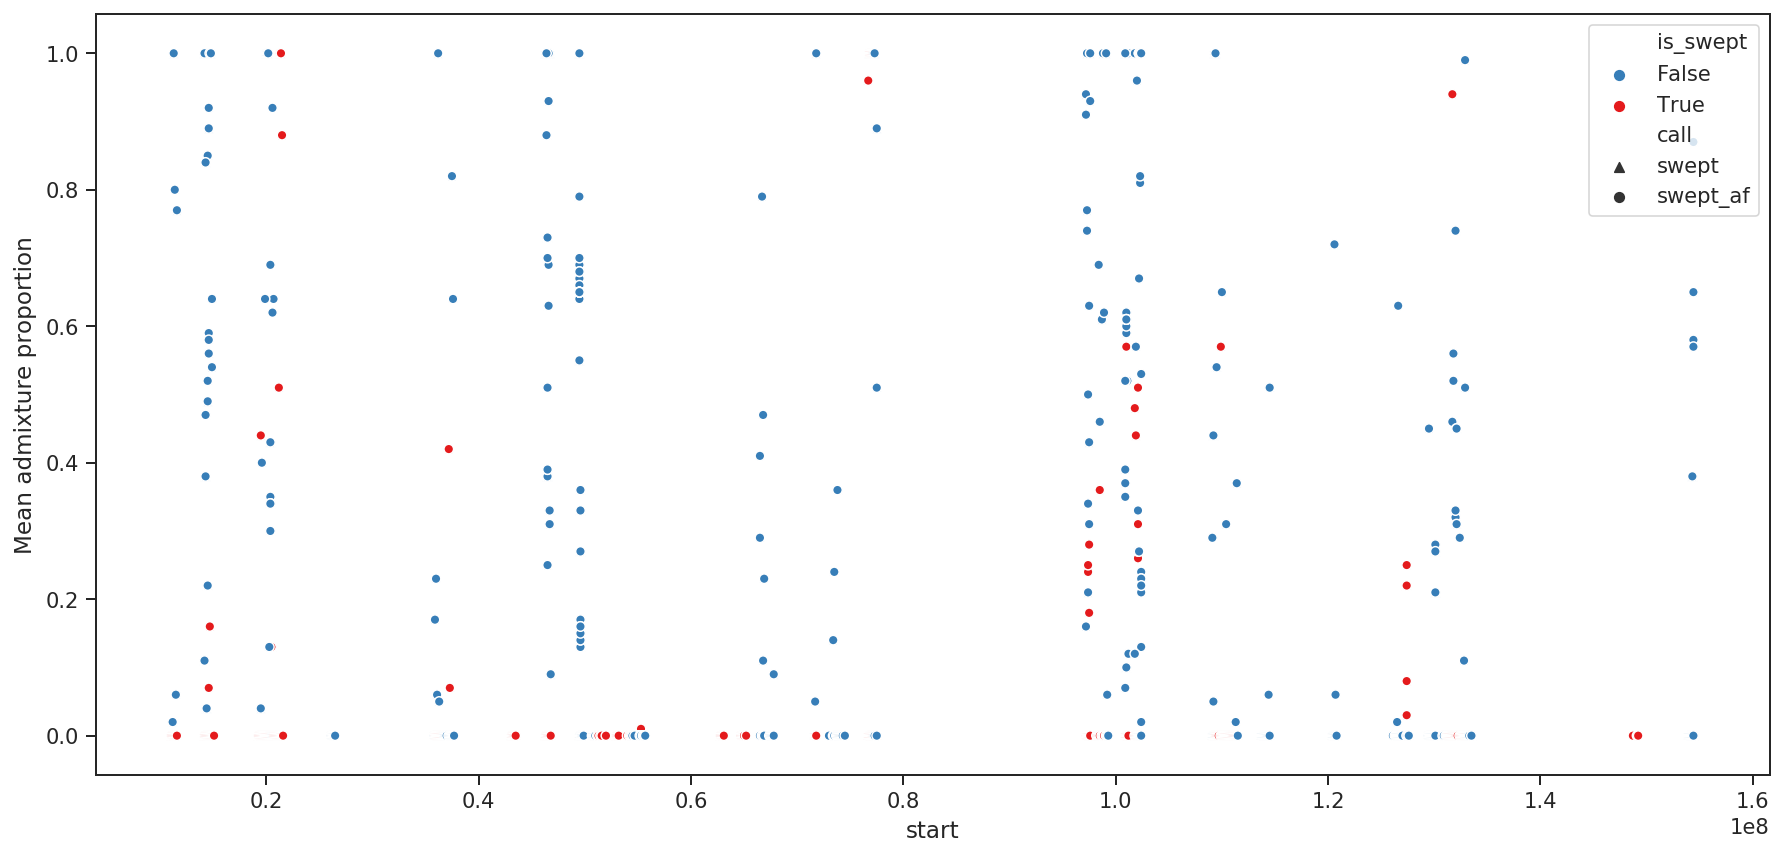

In [106]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            plt.figure(figsize=(15,7))
            g = sns.scatterplot(x='start', y='admix_prop', style='call', hue='is_swept', markers=['^', 'o'], data=plot_df)
            g.set_ylabel('Mean admixture proportion')

In [107]:
#pandas.pivot_table(plot_df, index=['start', 'admix_prop'], columns='is_swept')

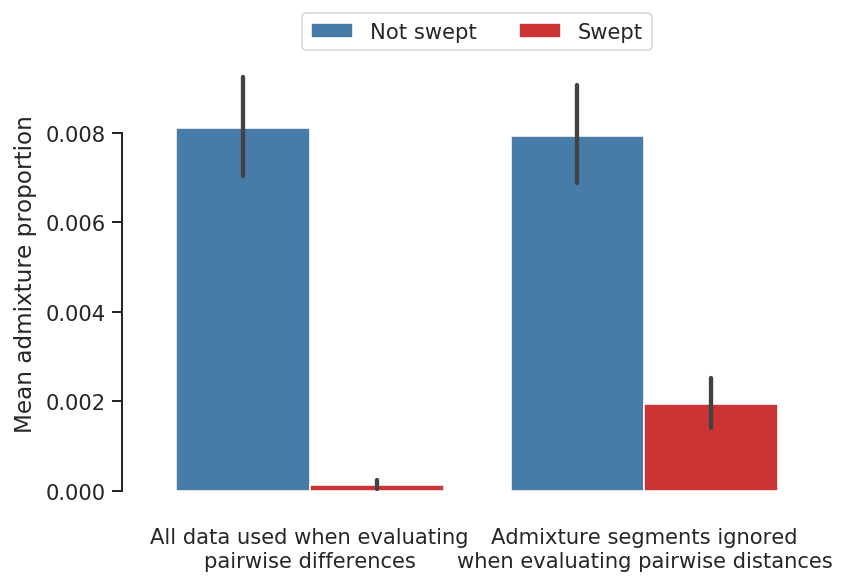

In [108]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='call', y='admix_prop', hue='is_swept', data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()

            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',
                     ncol=2
                    )
            
            sns.despine(trim=True, offset=10)

            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            ) # labels along the bottom edge are off
            plt.gca().axes.spines['bottom'].set_visible(False)
                
            plt.savefig(str(figures_dir / 'admix_prop_by_call.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call.png'))

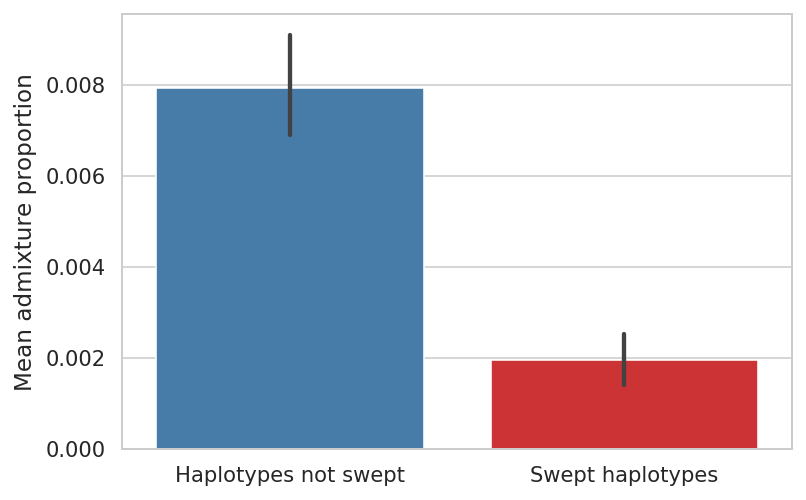

In [109]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='is_swept', y='admix_prop', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af']
                           )
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['Haplotypes not swept', 'Swept haplotypes'])

            plt.savefig(str(figures_dir / 'admix_prop_af.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_af.png'))

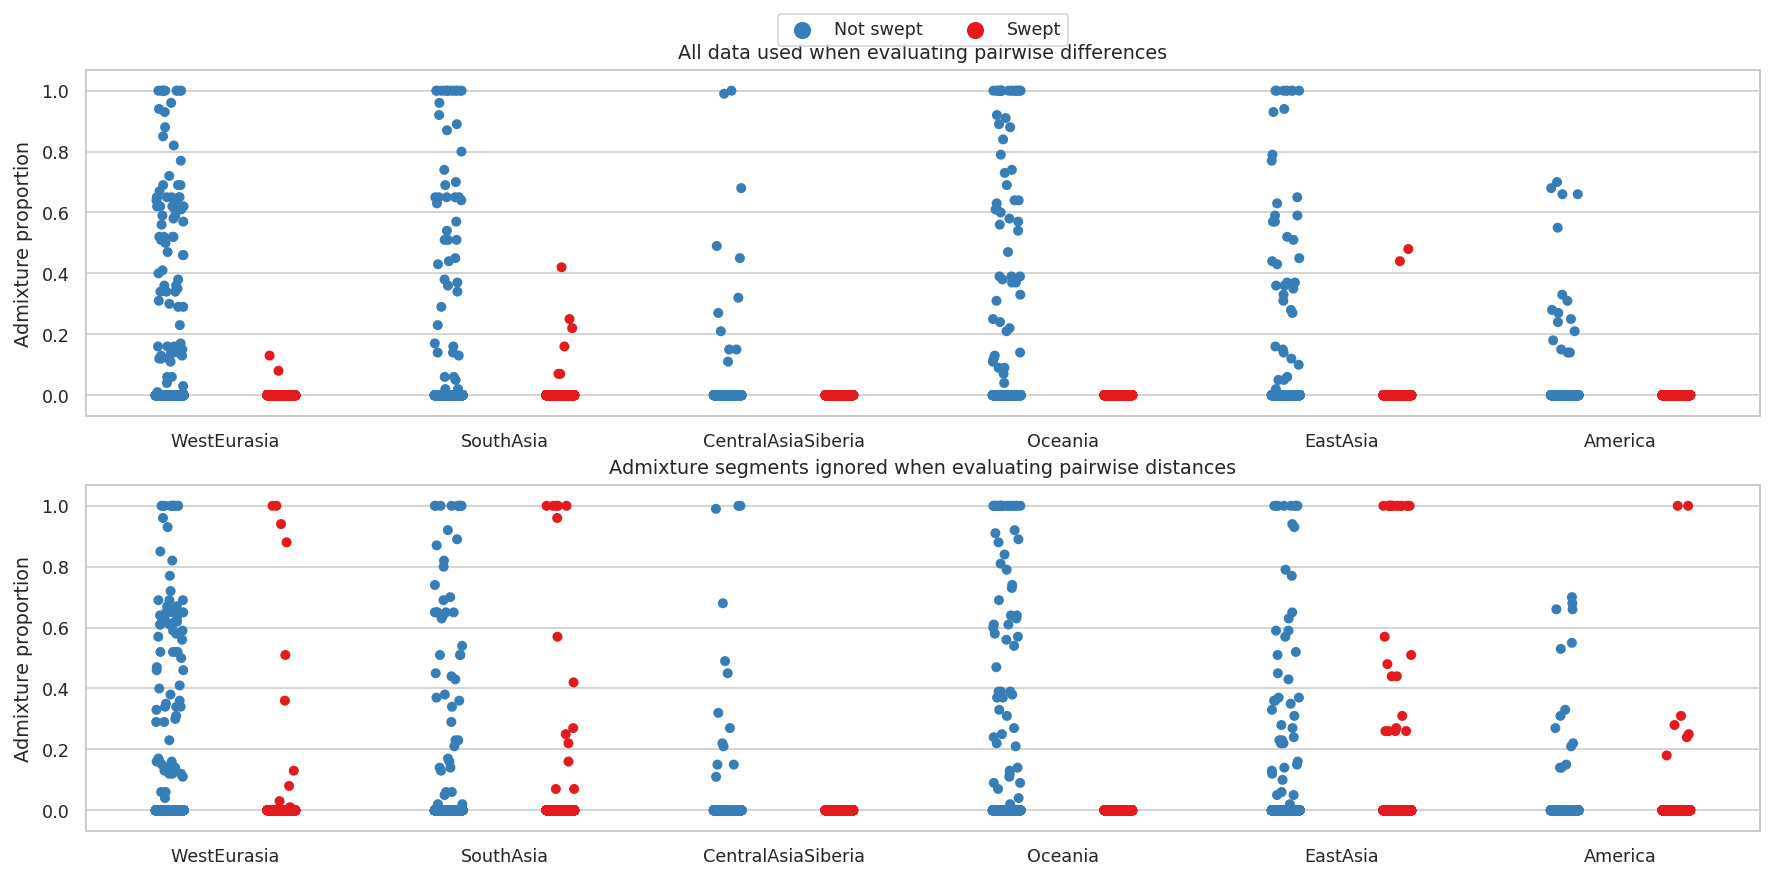

In [110]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=True)

            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

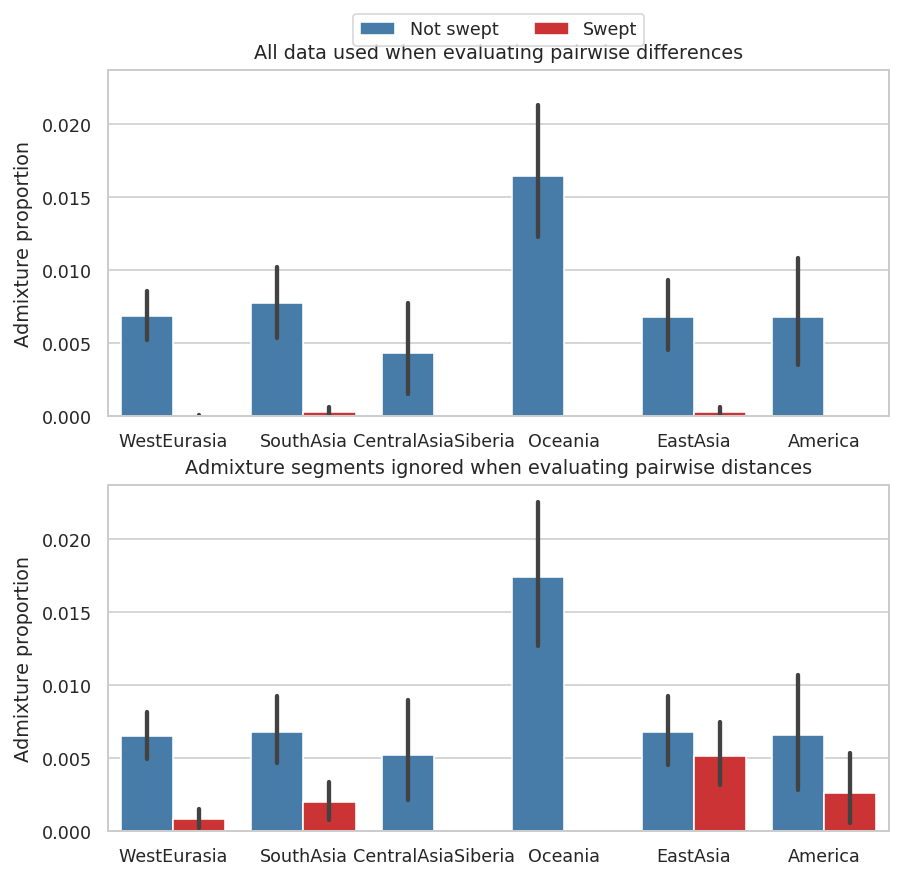

In [111]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharey=True)

            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.png'))

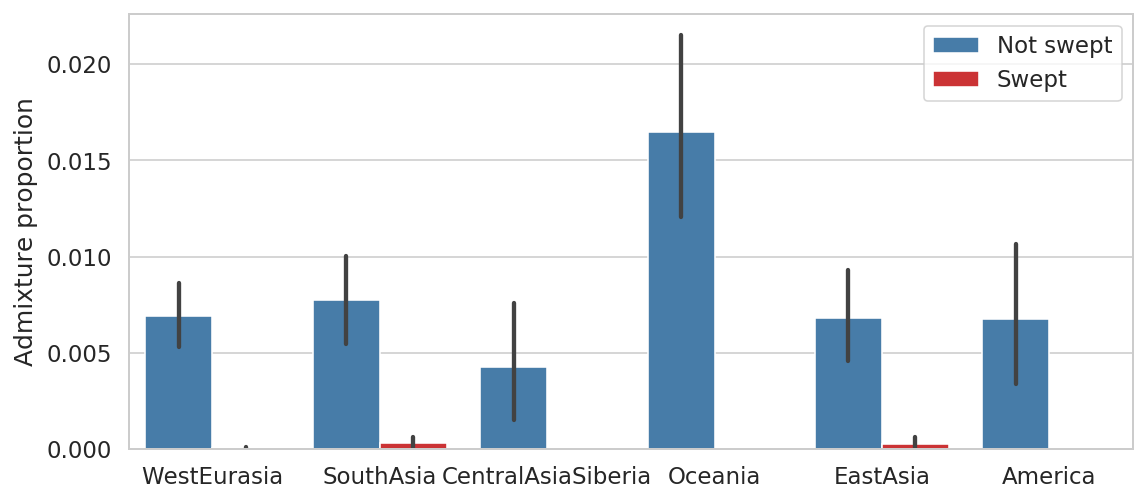

In [112]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.3):
            
            fig, ax = plt.subplots(1, 1, figsize=(9, 4))
                
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )

            g.legend(handles, ['Not swept', 
                               'Swept',
                              ],
                     loc='upper right',
                     ncol=1
                    )
            plt.savefig(str(figures_dir / 'admix_prop_by_region.pdf'))


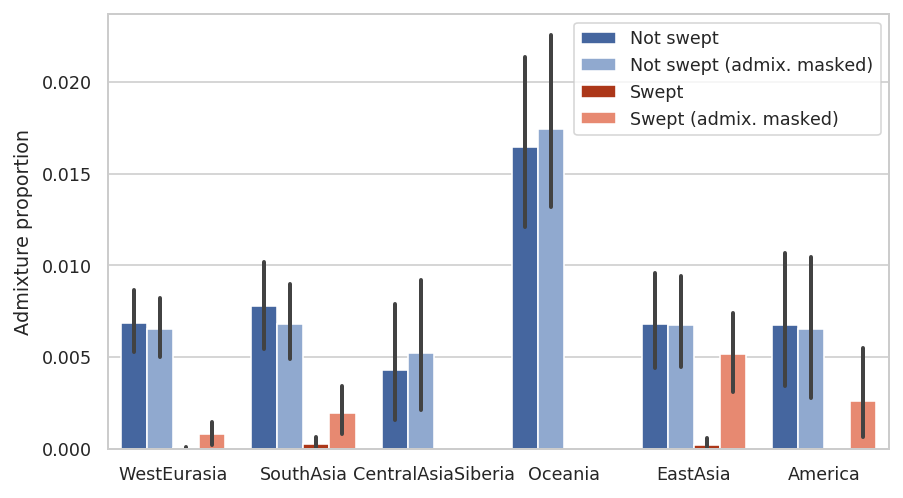

In [113]:
with sns.color_palette(["#3662AE", "#86A7D9", "#C52900", "#FB7D5D"]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))

            g = sns.barplot(x='region_1', y='admix_prop', hue='label', 
                            data=plot_df.assign(label=plot_df.call.astype(str) + "_" + plot_df.is_swept.astype(str)), 
                            hue_order=['swept_False', 'swept_af_False', 'swept_True', 'swept_af_True'],
                            ax=ax1,
                            errwidth=2,
                            #width = .8
                           )

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 
                               'Not swept (admix. masked)',
                               'Swept',
                               'Swept (admix. masked)',
                              ],
                     #bbox_to_anchor=(1., 1.0),  loc='upper left',
                     loc='upper right',
#                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=1
                    )

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region_version2.pdf'))

Admixture proportions:

In [114]:
(plot_df
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
)

mean       sem
call     region_1           is_swept                    
swept    WestEurasia        False     0.006886  0.000861
                            True      0.000035  0.000025
         SouthAsia          False     0.007760  0.001225
                            True      0.000299  0.000143
         CentralAsiaSiberia False     0.004281  0.001575
                            True      0.000000  0.000000
         Oceania            False     0.016462  0.002419
                            True      0.000000  0.000000
         EastAsia           False     0.006796  0.001249
                            True      0.000241  0.000171
         America            False     0.006773  0.001937
                            True      0.000000  0.000000
swept_af WestEurasia        False     0.006517  0.000827
                            True      0.000805  0.000329
         SouthAsia          False     0.006809  0.001113
                            True      0.001986  0.000640
         CentralAsiaSiberia False     0.005234  0.001772
                            True      0.000000  0.000000
         Oceania            False     0.017405  0.002463
                            True      0.000000  0.000000
         EastAsia           False     0.006777  0.001220
                            True      0.005179  0.001081
         America            False     0.006553  0.001978
                            True      0.002627  0.001227

In the admixture filtered analysis, confidence intervals for mean admixture proportions overlap, or nearly overlap zero. Add to that that Laurit's method has a false positive rate of 5-10%.

In [115]:
(plot_df.loc[lambda df: (df.call=='swept_af') & (df.is_swept==True)]
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
 .reset_index()
 .assign(non_zero=lambda df: df['mean']-1.96*df['sem'])
)

call            region_1  is_swept      mean       sem  non_zero
0  swept_af         WestEurasia      True  0.000805  0.000329  0.000161
1  swept_af           SouthAsia      True  0.001986  0.000640  0.000732
2  swept_af  CentralAsiaSiberia      True  0.000000  0.000000  0.000000
3  swept_af             Oceania      True  0.000000  0.000000  0.000000
4  swept_af            EastAsia      True  0.005179  0.001081  0.003060
5  swept_af             America      True  0.002627  0.001227  0.000221

### Chromosome wide admixture proportion excluding the swept haplotypes we call:

Compute mean admixture of each 100kb window when sweept windows are excluded and then compute chromosome mean:

In [116]:
chrom_admix_without_sweeps = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix_without_sweeps

mean       sem     upper    lower
admix_prop  0.007811  0.001307  0.010372  0.00525

In [117]:
chrom_admix = (plot_df
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix

mean       sem    upper     lower
admix_prop  0.004877  0.000797  0.00644  0.003314

In [118]:
(chrom_admix_without_sweeps['mean'] - chrom_admix['mean']) / chrom_admix_without_sweeps['mean']

admix_prop    0.375597
Name: mean, dtype: float64

Same but by region:

In [119]:
chrom_admix_without_sweeps_by_region = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_without_sweeps_by_region

mean       sem     upper     lower
region_1                                                  
WestEurasia         0.005914  0.001248  0.008360  0.003469
SouthAsia           0.008254  0.001781  0.011746  0.004762
CentralAsiaSiberia  0.005533  0.002222  0.009888  0.001178
Oceania             0.013602  0.002857  0.019201  0.008003
EastAsia            0.007677  0.002201  0.011990  0.003364
America             0.004822  0.002781  0.010273 -0.000630

Same computation but inlcuding all windows for al individuals:

In [120]:
chrom_admix_by_region = (plot_df
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_by_region

mean       sem     upper     lower
region_1                                                  
WestEurasia         0.003716  0.000729  0.005146  0.002287
SouthAsia           0.004411  0.000718  0.005819  0.003003
CentralAsiaSiberia  0.002314  0.000907  0.004093  0.000535
Oceania             0.009479  0.001992  0.013383  0.005576
EastAsia            0.005896  0.001685  0.009199  0.002593
America             0.004219  0.001863  0.007870  0.000569

How much higher would the chromosome average admixture level be if we take out swept haplotypes:

In [121]:
(chrom_admix_without_sweeps_by_region['mean'] - chrom_admix_by_region['mean']) / chrom_admix_without_sweeps_by_region['mean']

region_1
WestEurasia           0.371628
SouthAsia             0.465571
CentralAsiaSiberia    0.581740
Oceania               0.303083
EastAsia              0.231933
America               0.124926
Name: mean, dtype: float64

### Plot below is not for use but only for keeping as template in case I do a more thorough analysis on Laurits larger Papuan set.

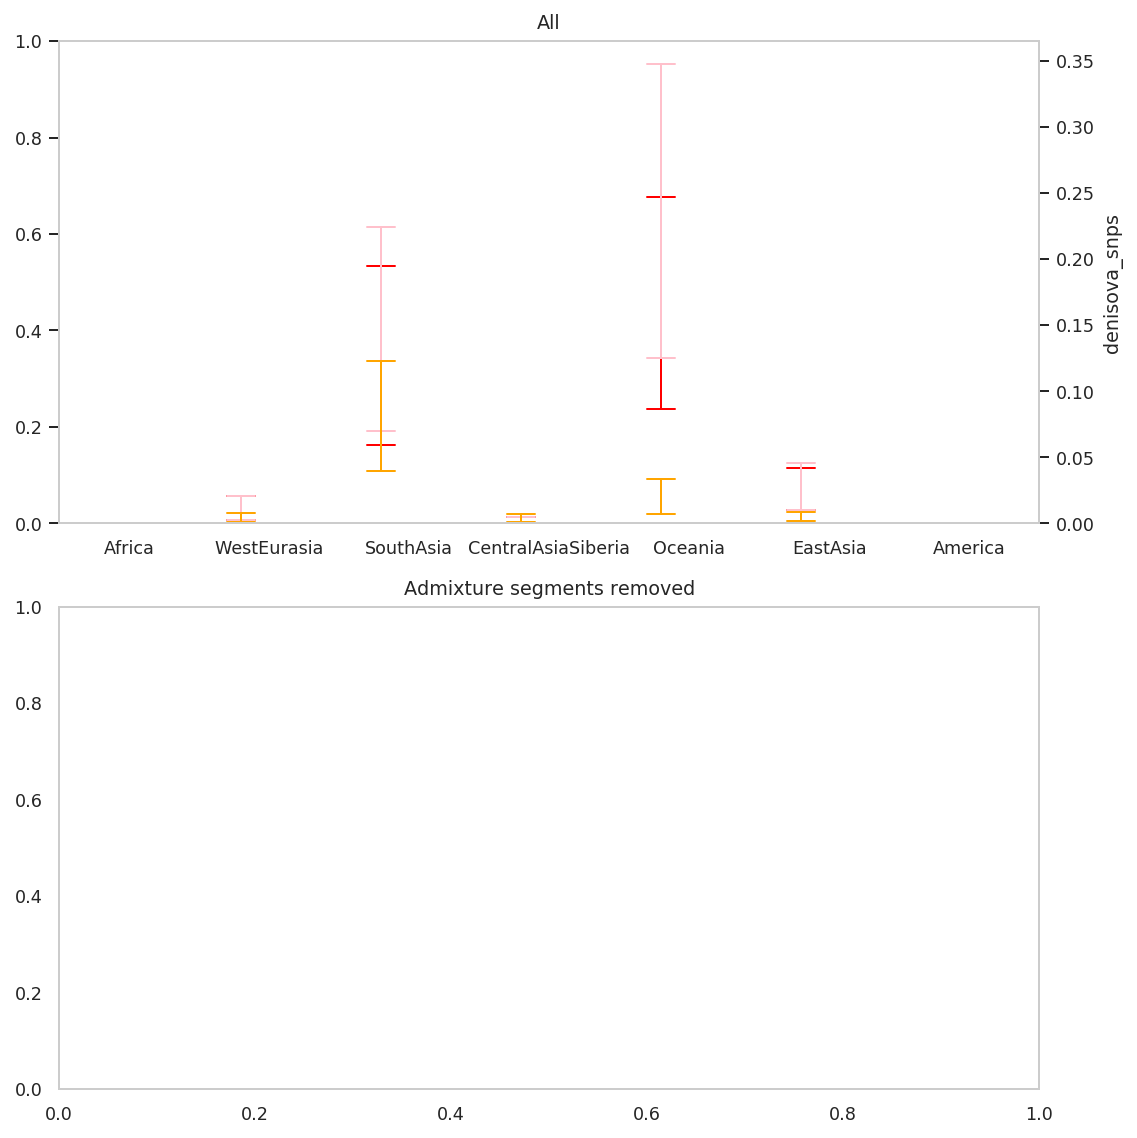

In [122]:
sweep_and_admix_data_subset = (merged_data
                               .groupby(['start'])
                               .filter(lambda df: df.swept.sum() > 0)
                              )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept', 
#                             data=merged_data.loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig')], 
#                             ax=ax1, n_boot=1000)
            ax1.grid(False)
            ax1.set_title("All")

            extra_ax = ax1.twinx()
            sns.barplot(x='region_1', y='altai_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="red")
            sns.barplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="pink")
            sns.barplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="orange")
            extra_ax.grid(False)
            extra_ax.legend_.remove()

            for item in g.get_xticklabels():
                item.set_rotation(25)

#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
#                 data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
#                             ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Admixture segments removed")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

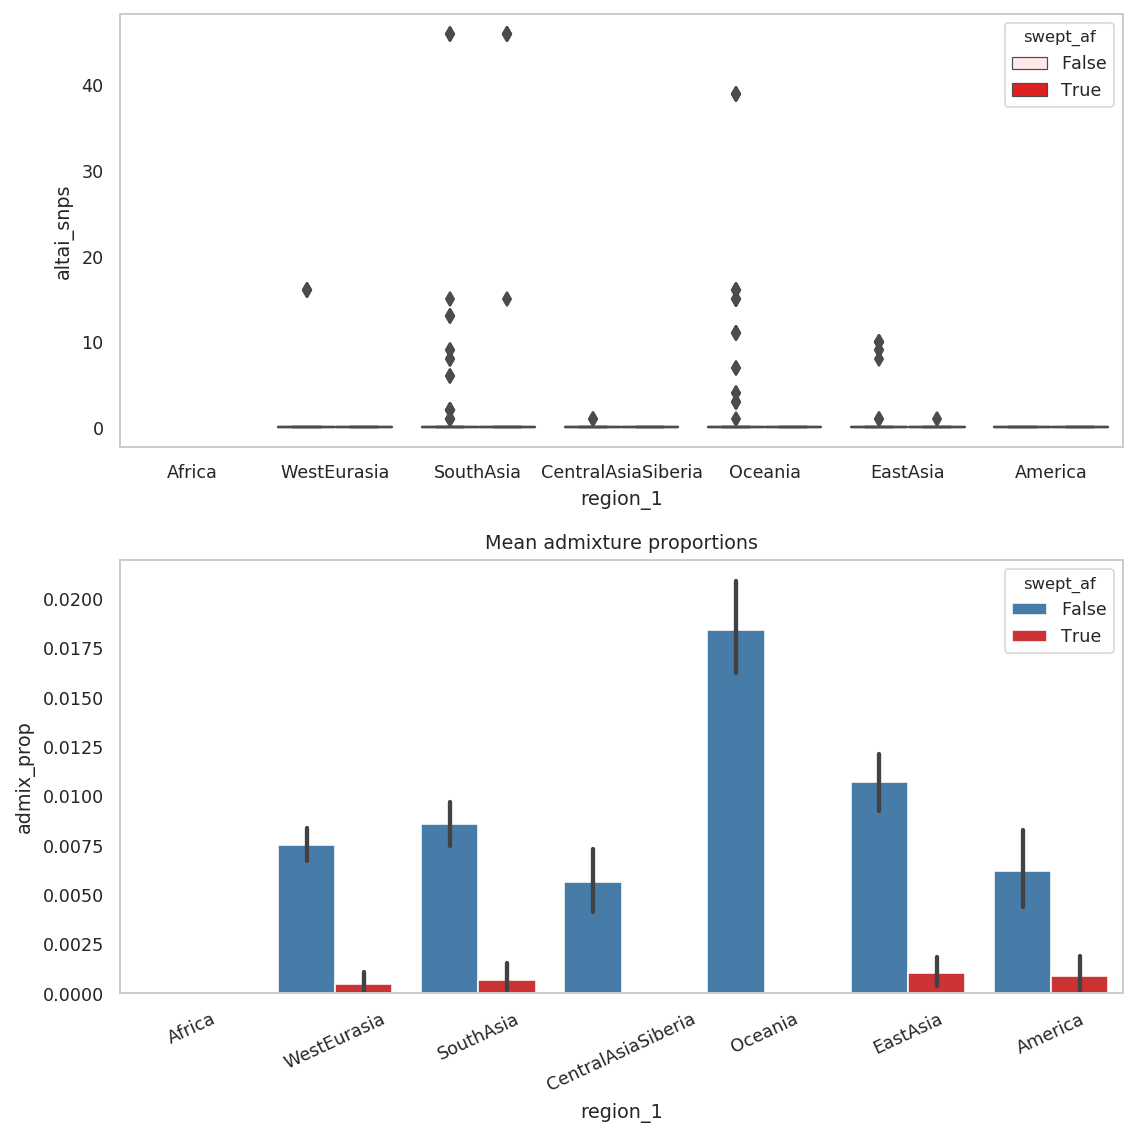

In [123]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

            ax1.grid(False)
            sns.boxplot(x='region_1', y='altai_snps', hue='swept_af', data=sweep_and_admix_data_subset, ax=ax1,
                         color="red")
#             sns.boxplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="pink")
#             sns.boxplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="orange")

            for item in g.get_xticklabels():
                item.set_rotation(25)

            g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
                data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
                            ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Mean admixture proportions")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

## Which swept windows have admixture when calling with admix filter?

In [124]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_data.loc[lambda df: (df.never_win_swept_af == False) & \
#                            (df.conserv_swept_group_af != 'ambig') &  \
                            (df.admix_prop > 0)]
            .sort_values(by=['admix_prop'], ascending=False))

indiv_1      start        end            pop_1  \
195592           S_Papuan-8    4000000    4100000           Papuan   
190362           S_Papuan-4  101800000  101900000           Papuan   
92593              S_Even-2  102500000  102600000             Even   
190954           S_Papuan-5    5800000    5900000           Papuan   
93583           S_Finnish-3   46300000   46400000          Finnish   
93584           S_Finnish-3   46400000   46500000          Finnish   
219178           S_Sindhi-1   34600000   34700000           Sindhi   
219179           S_Sindhi-1   34700000   34800000           Sindhi   
93585           S_Finnish-3   46500000   46600000          Finnish   
219180           S_Sindhi-1   34800000   34900000           Sindhi   
190356           S_Papuan-4  101200000  101300000           Papuan   
92563              S_Even-2   99500000   99600000             Even   
36579           S_Balochi-1   88300000   88400000          Balochi   
190355           S_Papuan-4  101100000  101200000           Papuan   
36575           S_Balochi-1   87900000   88000000          Balochi   
190354           S_Papuan-4  101000000  101100000           Papuan   
36568           S_Balochi-1   87200000   87300000          Balochi   
190353           S_Papuan-4  100900000  101000000           Papuan   
190352           S_Papuan-4  100800000  100900000           Papuan   
190351           S_Papuan-4  100700000  100800000           Papuan   
92592              S_Even-2  102400000  102500000             Even   
192511           S_Papuan-6    6300000    6400000           Papuan   
221994            S_Tajik-1    5800000    5900000            Tajik   
46939          S_BedouinB-1   37900000   38000000         BedouinB   
193521           S_Papuan-6  107300000  107400000           Papuan   
89424          S_Estonian-1   96000000   96100000         Estonian   
89425          S_Estonian-1   96100000   96200000         Estonian   
213039            S_Saami-2   41500000   41600000            Saami   
89426          S_Estonian-1   96200000   96300000         Estonian   
48225           S_Bengali-1   11300000   11400000          Bengali   
193520           S_Papuan-6  107200000  107300000           Papuan   
193519           S_Papuan-6  107100000  107200000           Papuan   
193518           S_Papuan-6  107000000  107100000           Papuan   
192512           S_Papuan-6    6400000    6500000           Papuan   
193517           S_Papuan-6  106900000  107000000           Papuan   
214234        S_Samaritan-1    5800000    5900000        Samaritan   
193516           S_Papuan-6  106800000  106900000           Papuan   
193452           S_Papuan-6  100400000  100500000           Papuan   
193143           S_Papuan-6   69500000   69600000           Papuan   
216036        S_Sardinian-1   30800000   30900000        Sardinian   
91626              S_Even-2    5800000    5900000             Even   
192513           S_Papuan-6    6500000    6600000           Papuan   
95555            S_French-1   88300000   88400000           French   
190350           S_Papuan-4  100600000  100700000           Papuan   
87407   S_Eskimo_Sireniki-1   49500000   49600000  Eskimo_Sireniki   
225999             S_Thai-1   95900000   96000000             Thai   
225098             S_Thai-1    5800000    5900000             Thai   
105430         S_Hawaiian-1  144600000  144700000         Hawaiian   
187843           S_Papuan-3    5100000    5200000           Papuan   
187836           S_Papuan-3    4400000    4500000           Papuan   
31821          S_Armenian-1   78100000   78200000         Armenian   
187835           S_Papuan-3    4300000    4400000           Papuan   
225180             S_Thai-1   14000000   14100000             Thai   
107272           S_Hazara-2   18400000   18500000           Hazara   
226000             S_Thai-1   96000000   96100000             Thai   
187850           S_Papuan-3    5800000    5900000           Papuan   
226001             S_Thai-1   

## Correlation between proportion of windows swept and admixture proportion in each individual

There is a relation between amount swept and admixtue, as would be expected if sweeps displace admixture.

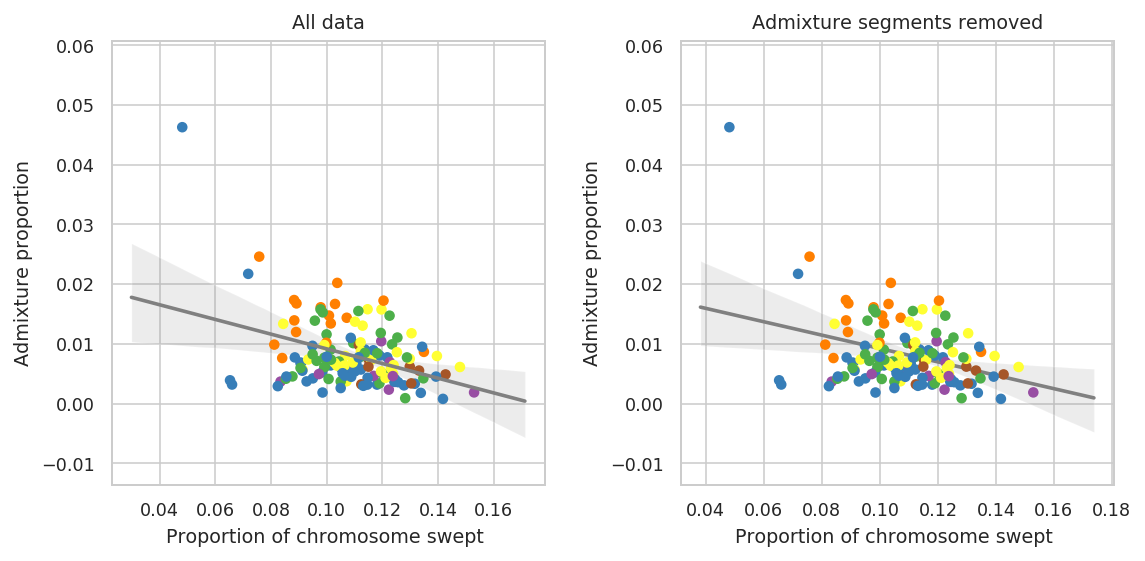

In [125]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
#           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.pdf'))


The same but with the following two outliers removed:

In [126]:
print(plot_df.loc[plot_df.admix_prop > 0.03])

           indiv_1     region_1     swept  swept_af  admix_prop
561  S_Jordanian-1  WestEurasia  0.048105  0.056122    0.046272


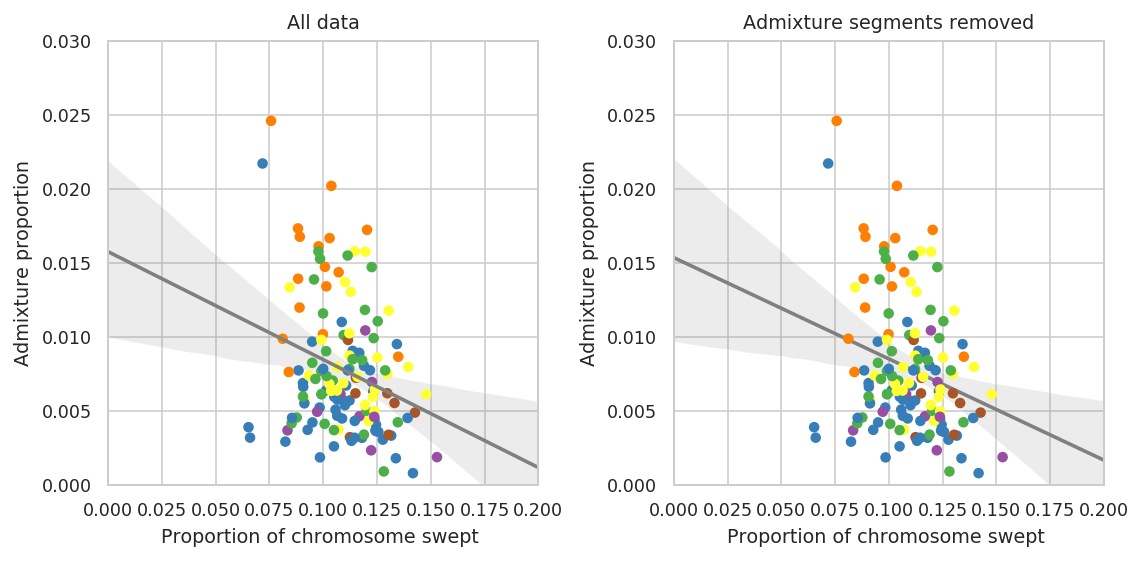

In [127]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

ax1.set_ylim(0, 0.03)
ax1.set_xlim(0, 0.2)
ax2.set_ylim(0, 0.03)
ax2.set_xlim(0, 0.2)

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.pdf'))


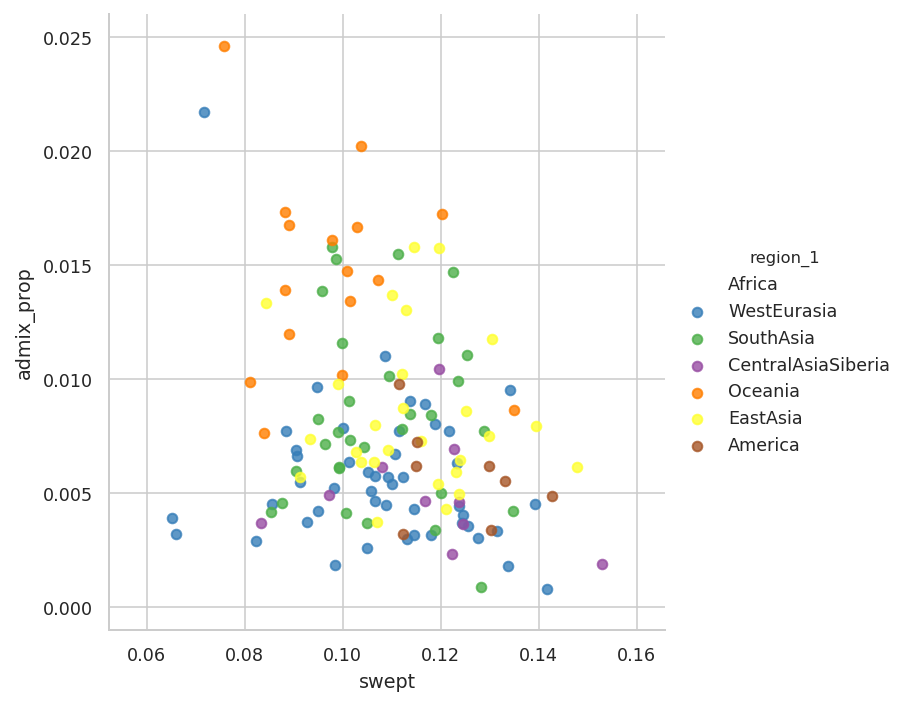

In [128]:
g = sns.lmplot(data=plot_df, 
               x='swept', y='admix_prop', hue='region_1', 
               fit_reg=False, palette='Set1')

## Admixture proportions across the X chromosome

Admixture and 75% regions:

In [129]:
# plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
#                     ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
# plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
#                       ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
# plot_df.reset_index(inplace=True)
# plot_df = stairs(plot_df)
# plot_df.head()

win_means = merged_data.loc[~merged_data.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
win_means['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
win_means['nr_swept'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
win_means['nr_total'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
win_means['prop_swept'] = win_means.nr_swept / win_means.nr_total
win_means.reset_index(inplace=True)

win_means.head()

start      end  admix_prop  admix_prop_not_sweept  nr_swept  nr_total  \
0  2700000  2800000    0.000000               0.000000       0.0       139   
1  2800000  2900000    0.005429               0.005429       0.0       140   
2  2900000  3000000    0.053143               0.053143       0.0       140   
3  3000000  3100000    0.011500               0.011500       0.0       140   
4  3100000  3200000    0.006429               0.006429       0.0       140   

   prop_swept  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

## Proportional reduction in admixture versus proportion swept

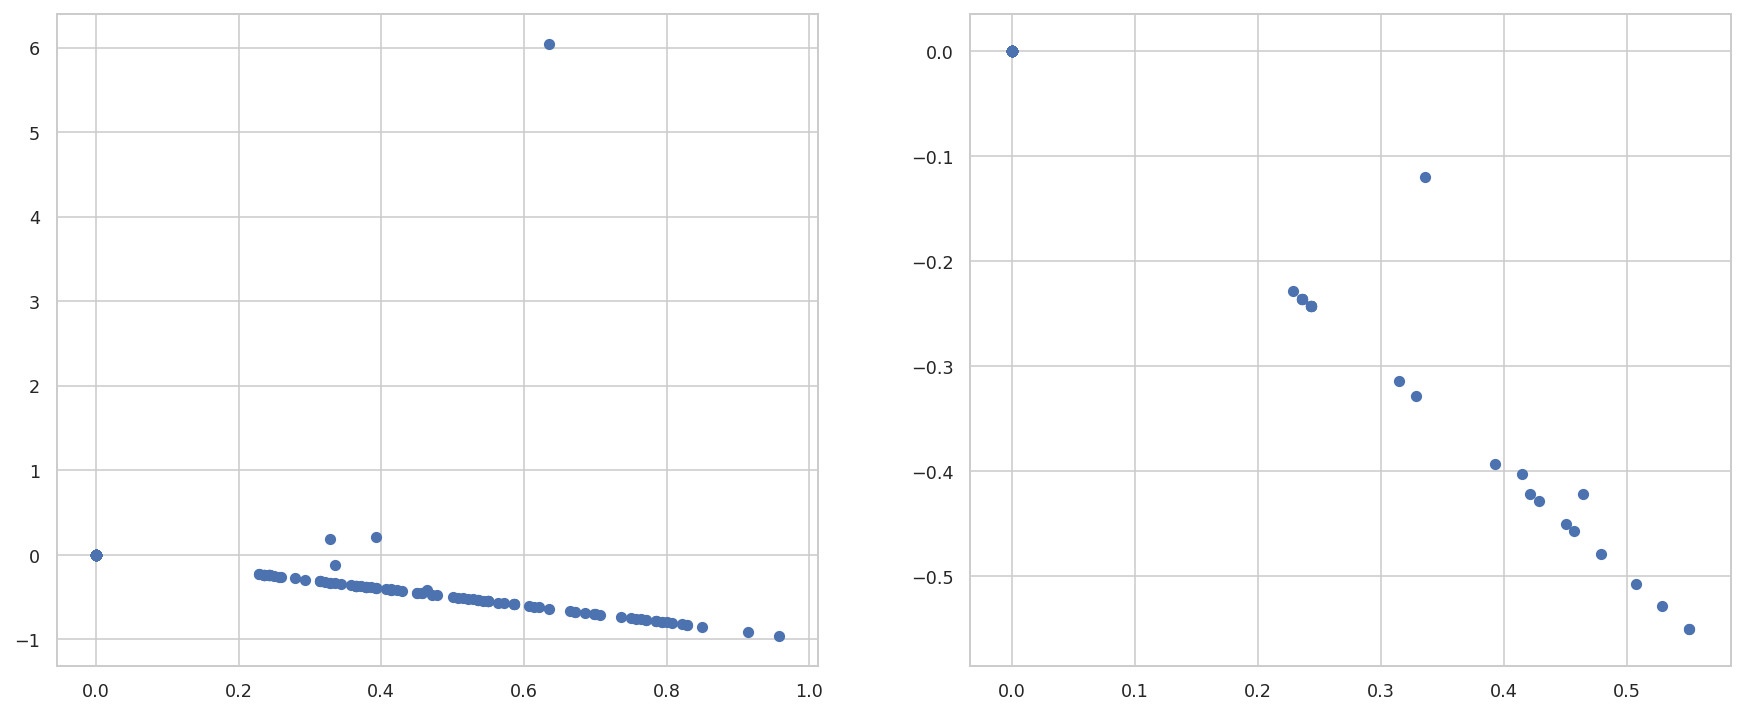

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_df = win_means
ax1.scatter(plot_df.prop_swept, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept) ;
plot_df = win_means.loc[win_means.admix_prop > 0.01]
ax2.scatter(plot_df.prop_swept, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept) ;

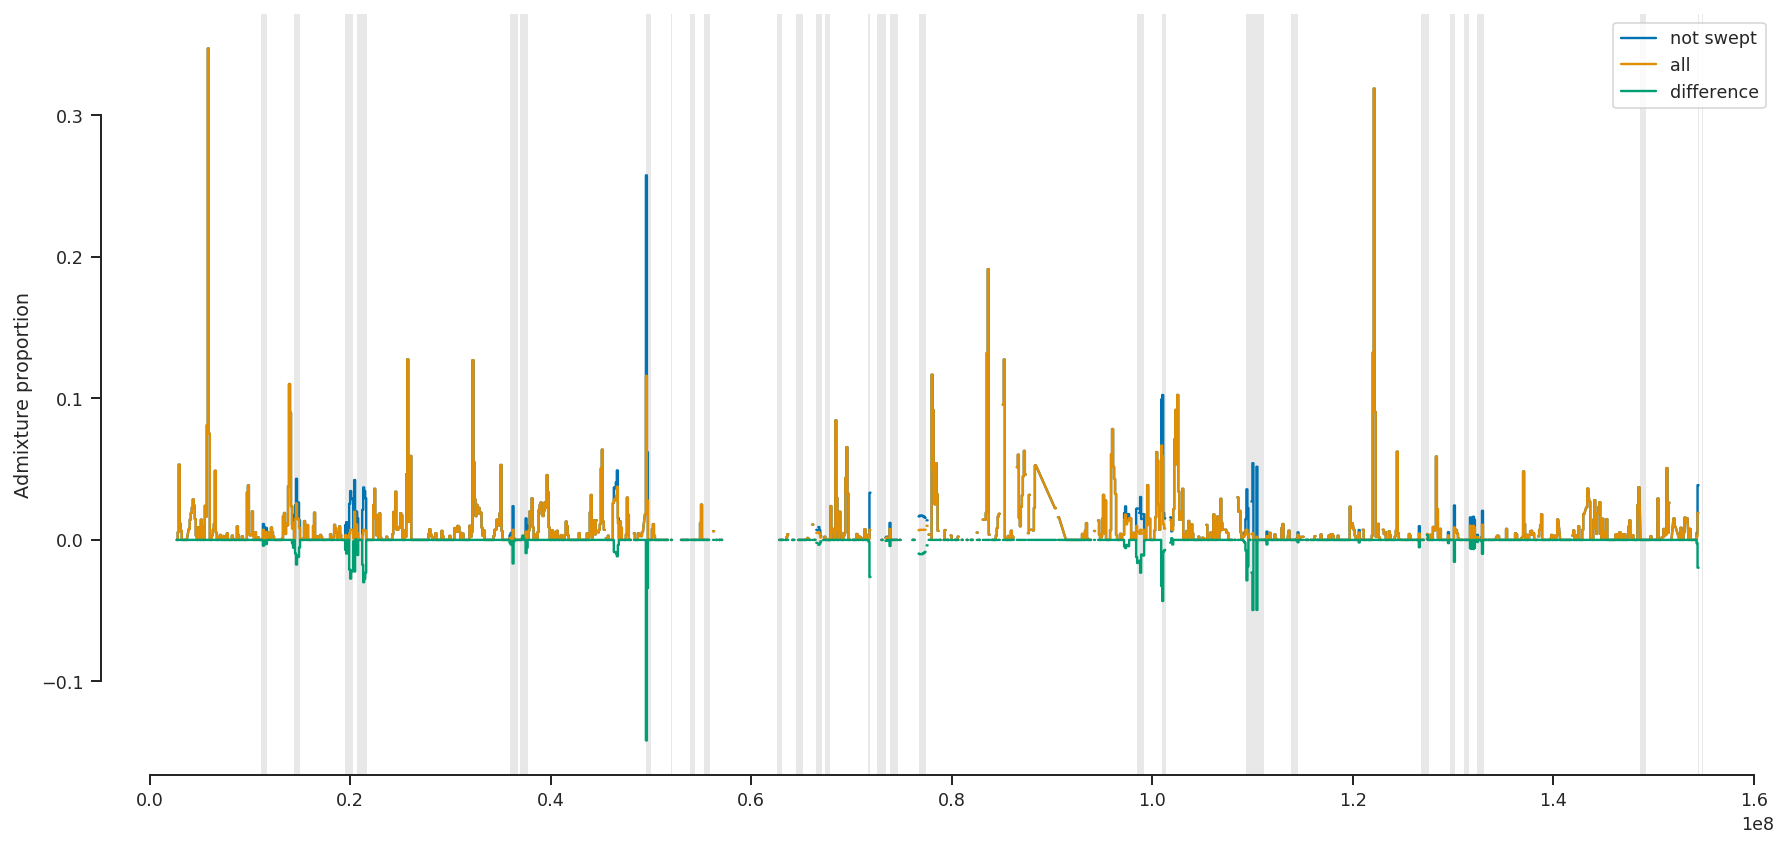

In [131]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_75.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            
        sns.despine(trim=True)

## Relative reduction in regions with sweeps 

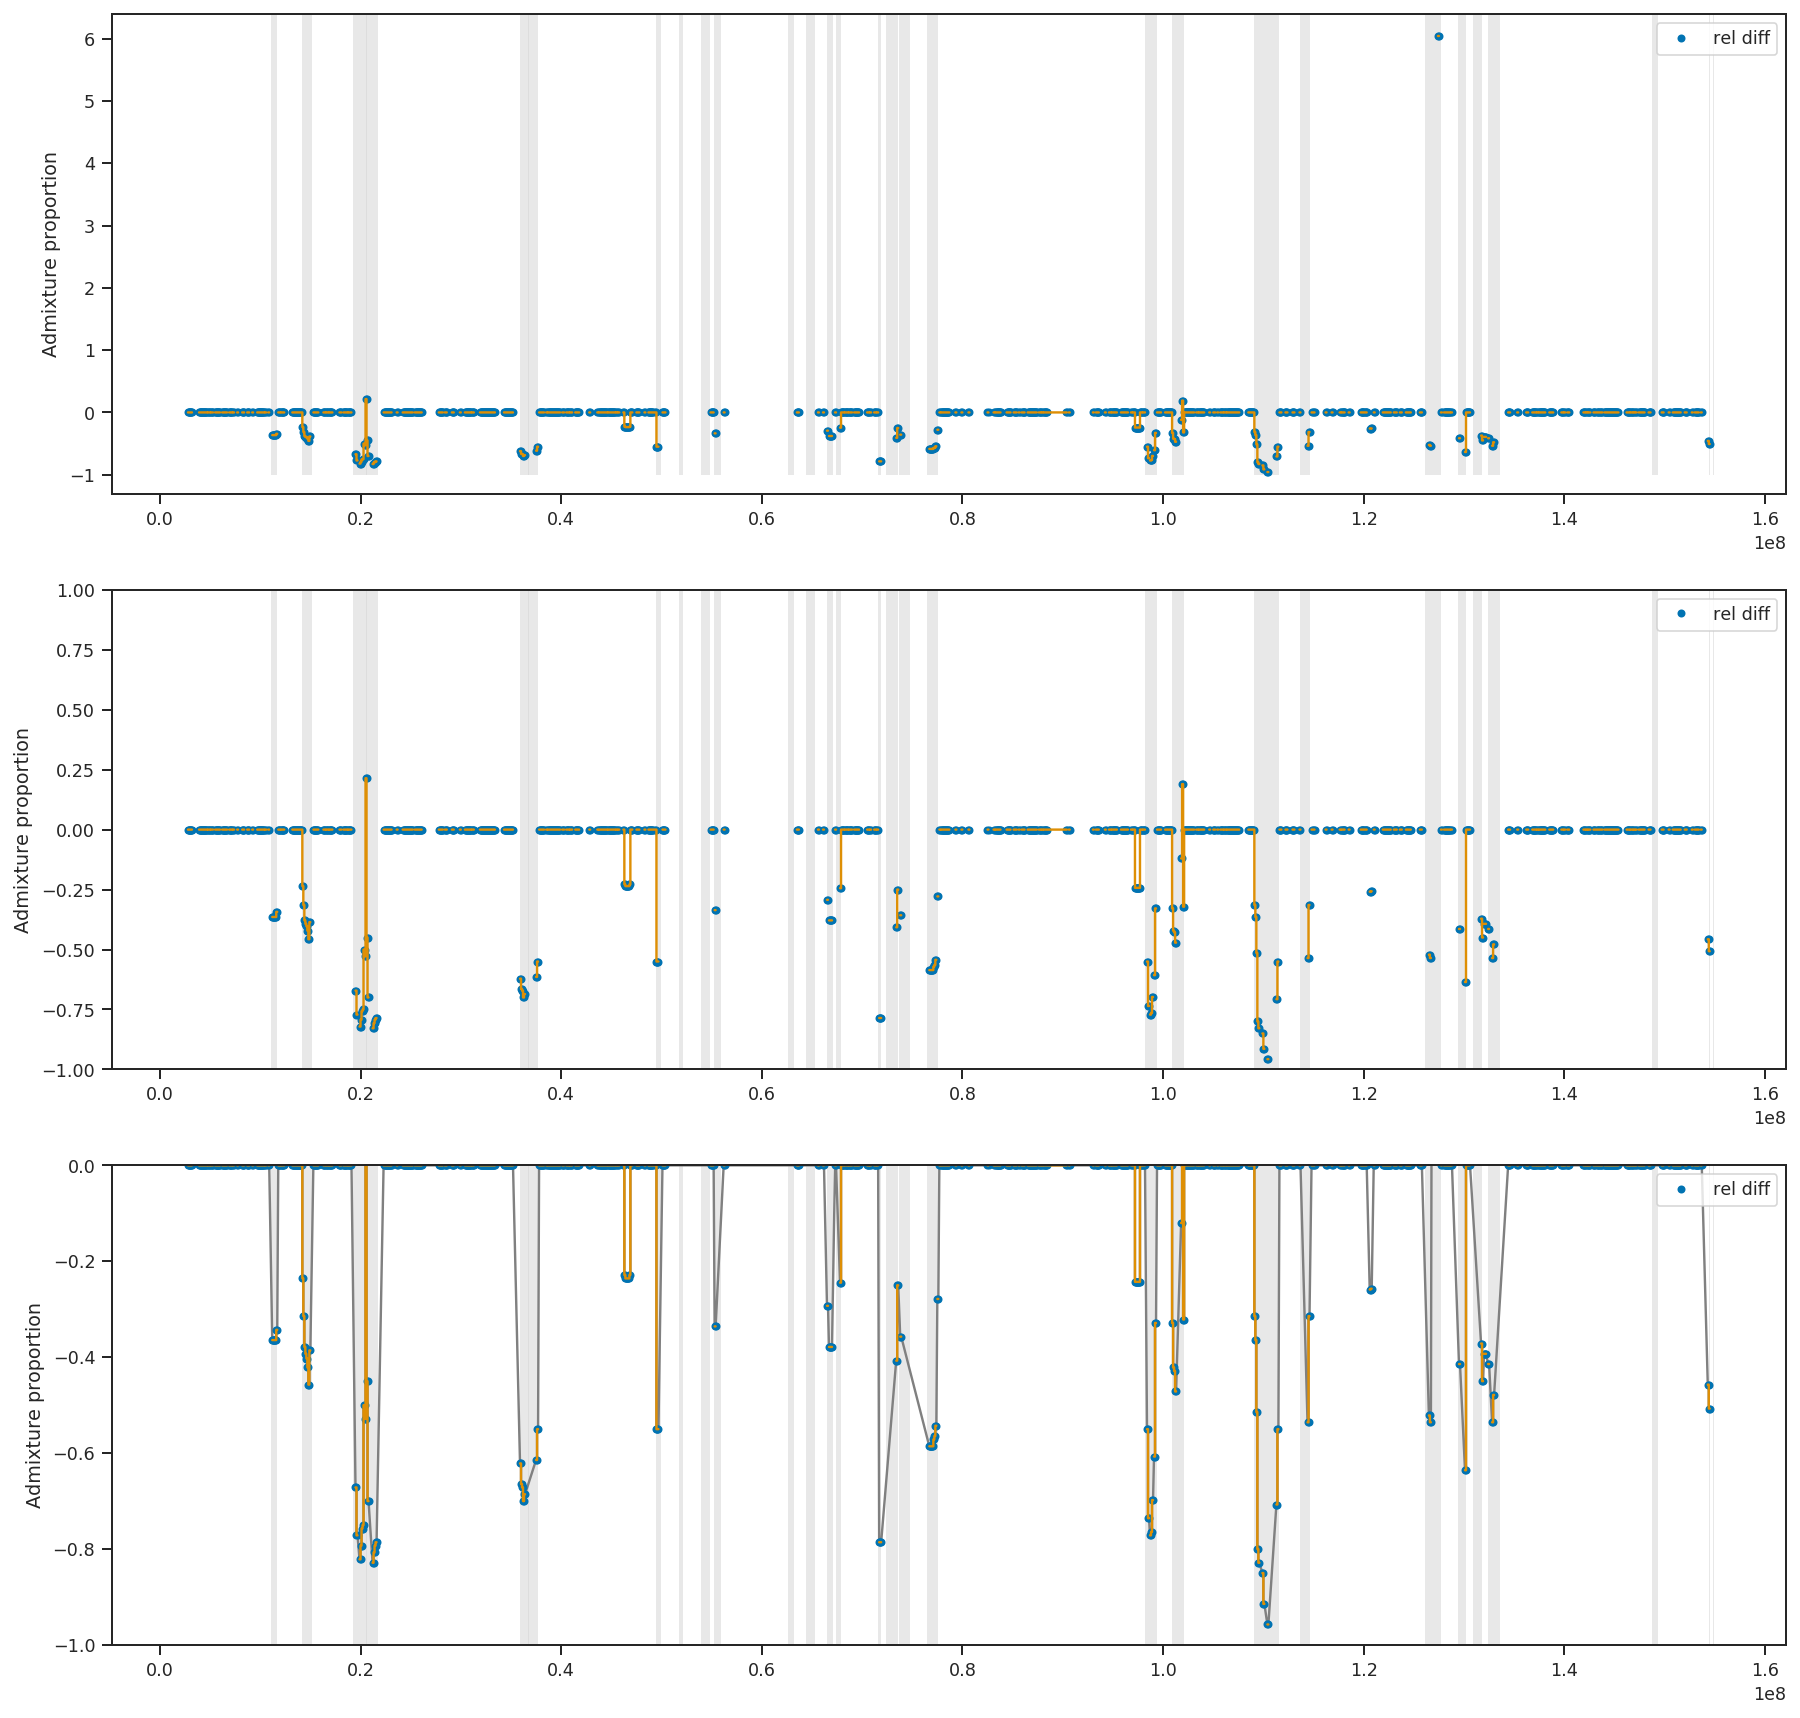

In [132]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        y = -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
        
        ax1.plot(plot_df.pos, y, label='rel diff', marker='o', markersize=3, linestyle='none')
        ax1.plot(plot_df.pos, y)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 8, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        ax2.plot(plot_df.pos, y, label='rel diff', marker='o', markersize=3, linestyle='none')
        ax2.plot(plot_df.pos, y)
        ax2.legend(loc='upper right')
        ax2.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 8, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
        ax2.set_ylim(-1, 1)
        
        ax3.plot(plot_df.pos.loc[numpy.isfinite(y)], y.loc[numpy.isfinite(y)], color='grey')
        ax3.plot(plot_df.pos, y, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax3.plot(plot_df.pos, y)


        ax3.legend(loc='upper right')
        ax3.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax3.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

#        sns.despine(trim=True)
        ax3.set_ylim(-1, 0)

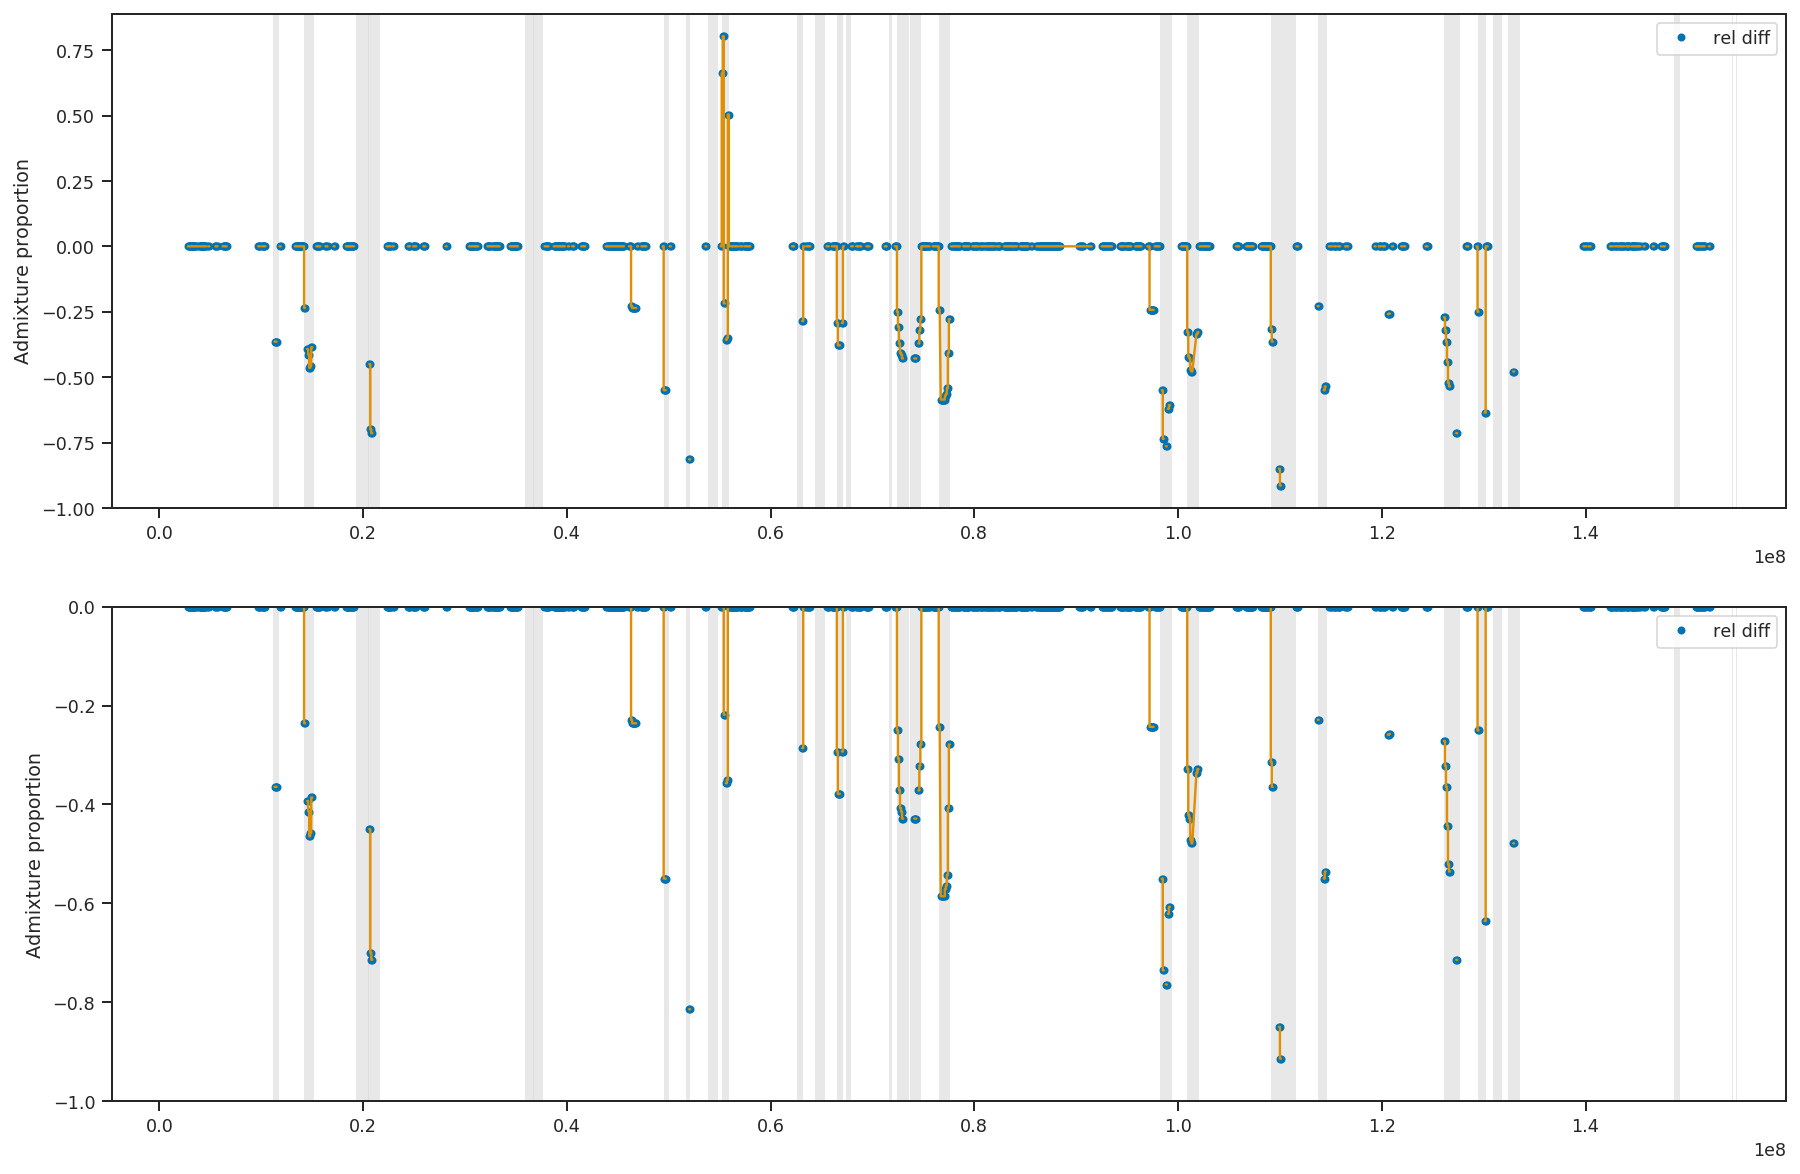

In [133]:
win_means_full = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
win_means_full['admix_prop_not_sweept'] = merged_data_full.loc[(merged_data_full.swept == False) & ~merged_data_full.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
win_means_full['nr_swept'] = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
win_means_full['nr_total'] = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
win_means_full['prop_swept'] = win_means_full.nr_swept / win_means_full.nr_total
win_means_full.reset_index(inplace=True)

win_means_full.head()

plot_df = stairs(win_means_full)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        ax2.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax2.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax2.legend(loc='upper right')
        ax2.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

#        sns.despine(trim=True)
        ax2.set_ylim(-1, 0)

**NB: set plot_df back to analysis without repeats:**

In [134]:
plot_df = stairs(win_means)

In [135]:
# plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
#                     ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
# plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
#                       ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
# plot_df['nr_swept'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
#                       ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
# plot_df['nr_total'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
#                       ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
# plot_df['prop_swept'] = plot_df.nr_swept / plot_df.nr_total
# plot_df.reset_index(inplace=True)
# #plot_df = stairs(plot_df)
# plot_df.head()

Admixture and ILS, ampl. regions and 10% regions:

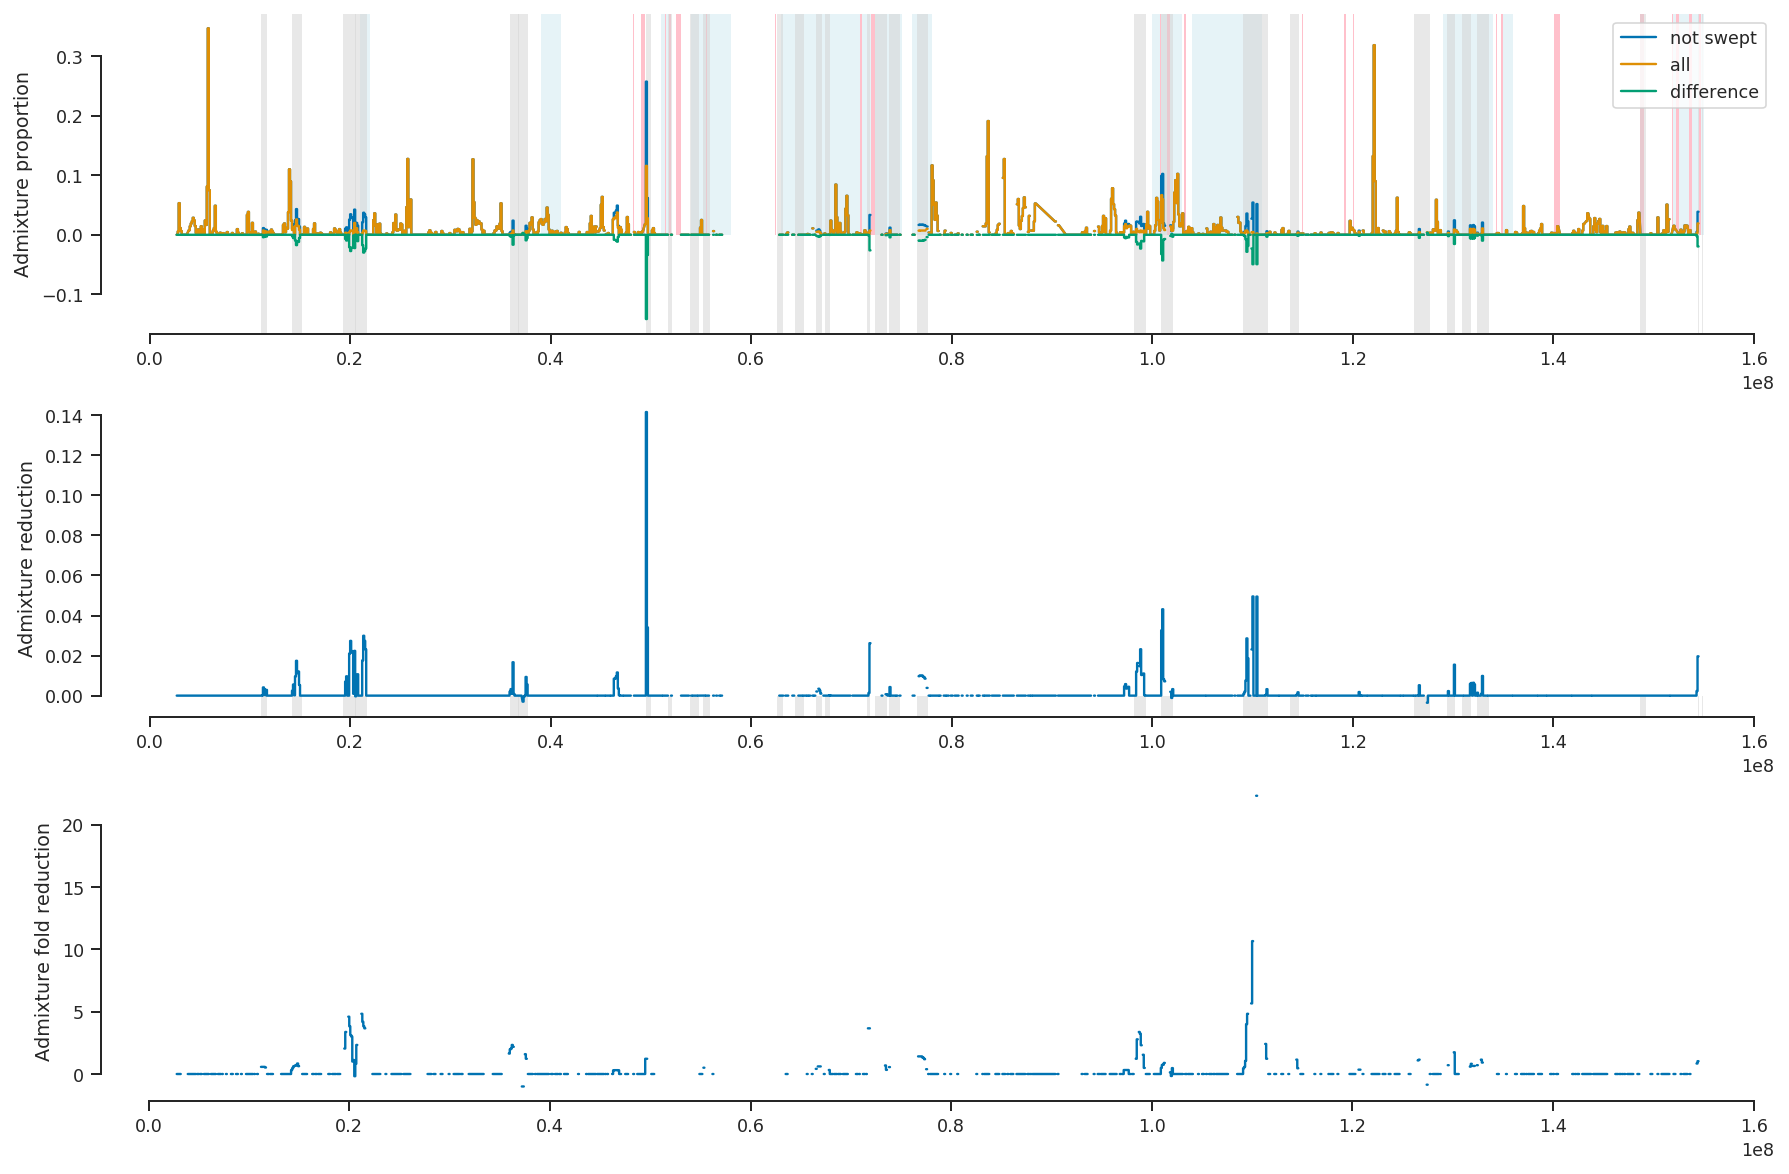

In [136]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')
        
        ax2.plot(plot_df.pos, plot_df.admix_prop_not_sweept - plot_df.admix_prop)
        ax2.set_ylabel('Admixture reduction')

        ax3.plot(plot_df.pos, (plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop)
        ax3.set_ylabel('Admixture fold reduction')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 1, 
                 facecolor='lightgray', 
                 linewidth=0,
        #              edgecolor=None,
                 alpha=0.5,
                 zorder=1))
            
        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='lightblue',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
            
        for tup in ampliconic_regions.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='pink',
                         linewidth=0,
                         alpha=1,
                         zorder=0))            
            
            
        sns.despine(trim=True)
#mpld3.display() 

In [137]:
#mpld3.display(fig)        

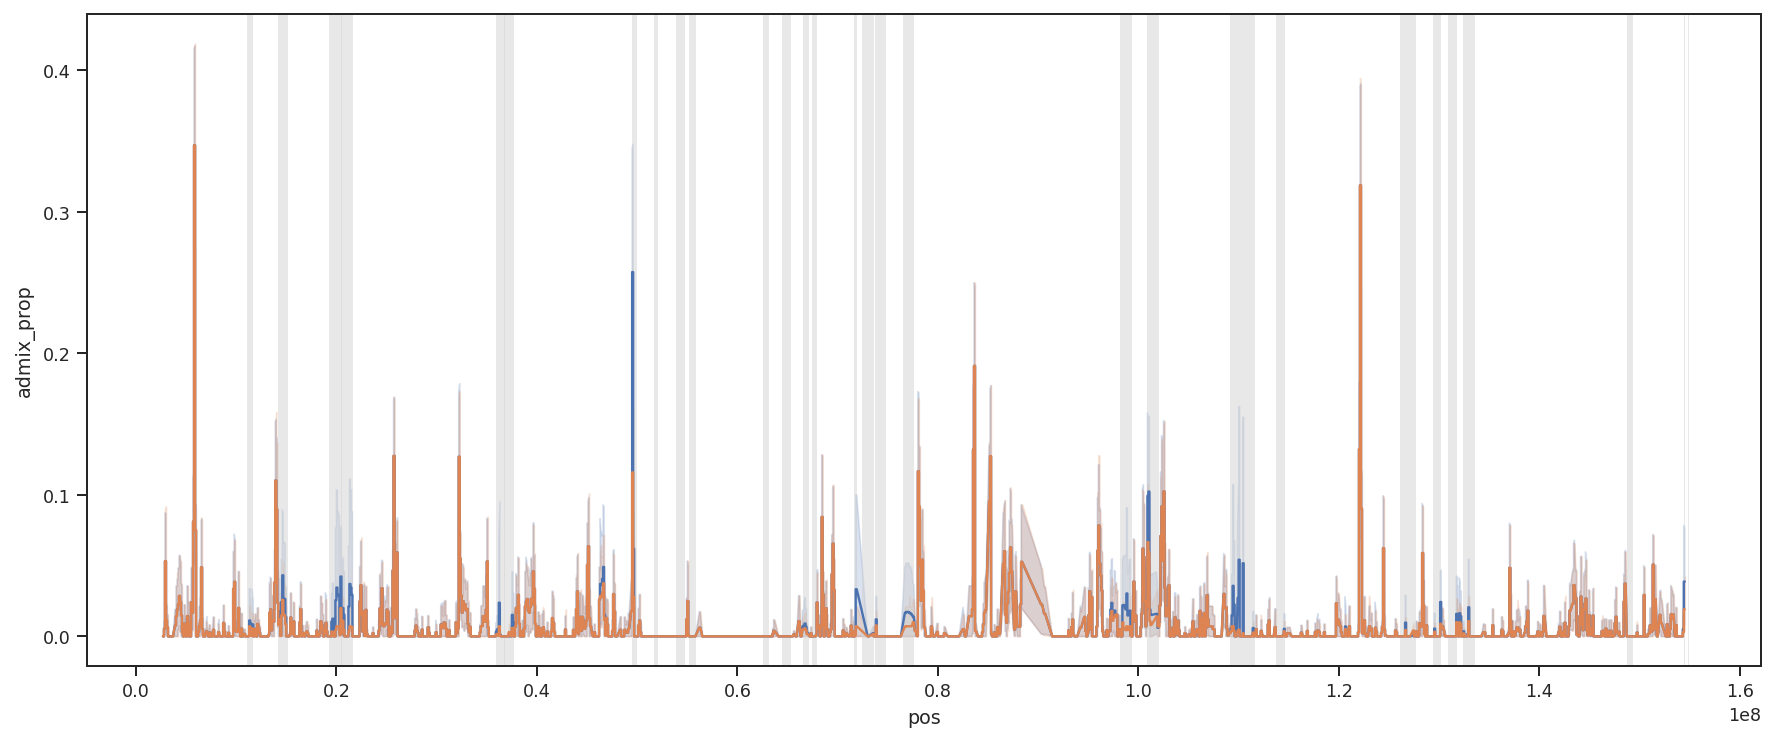

In [138]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))

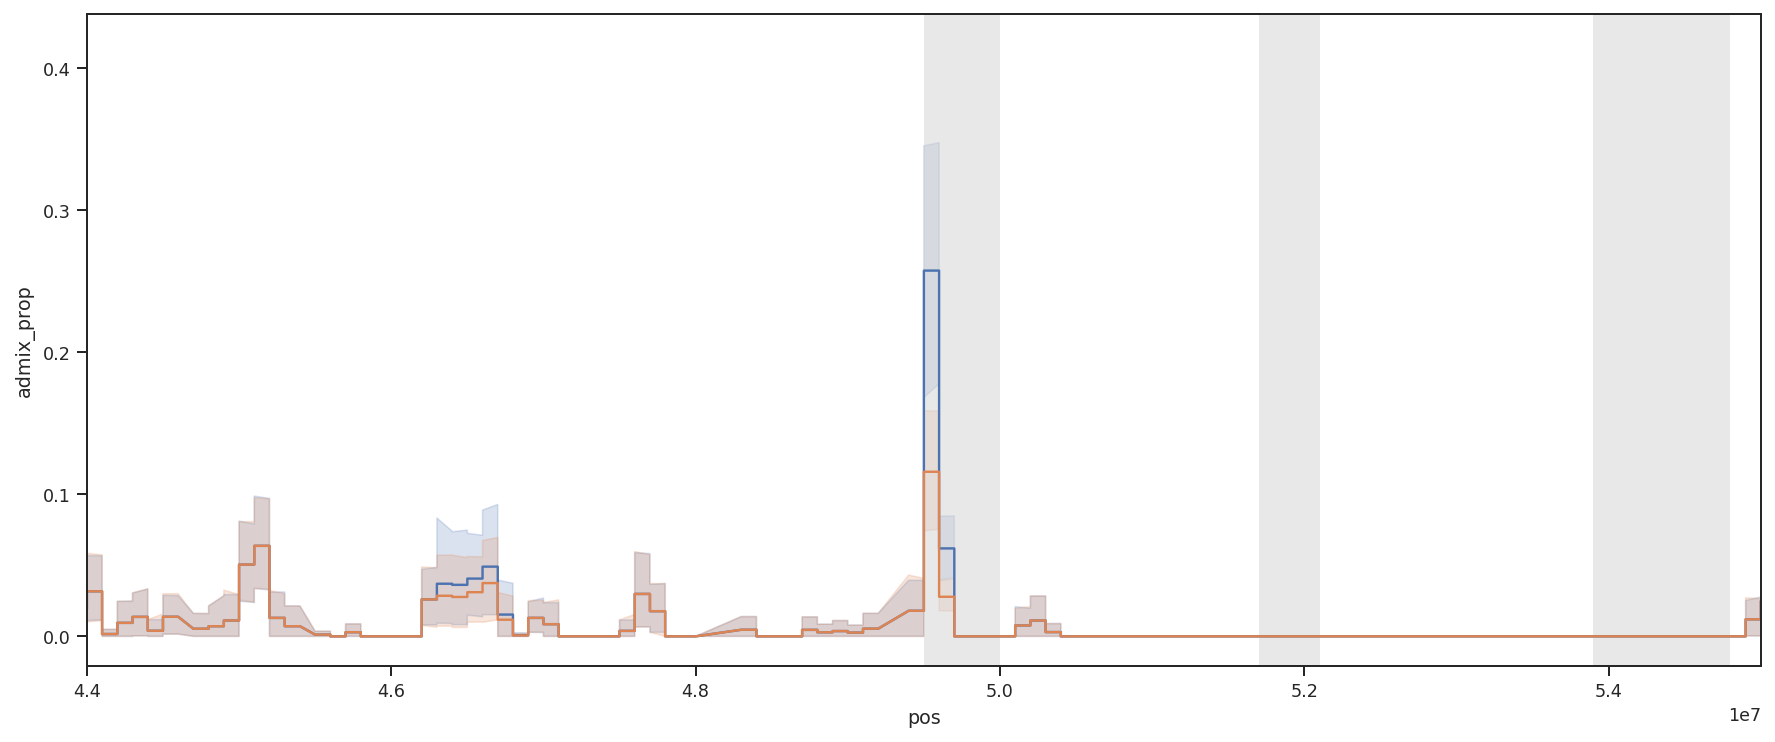

In [139]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(44e6, 55e6)

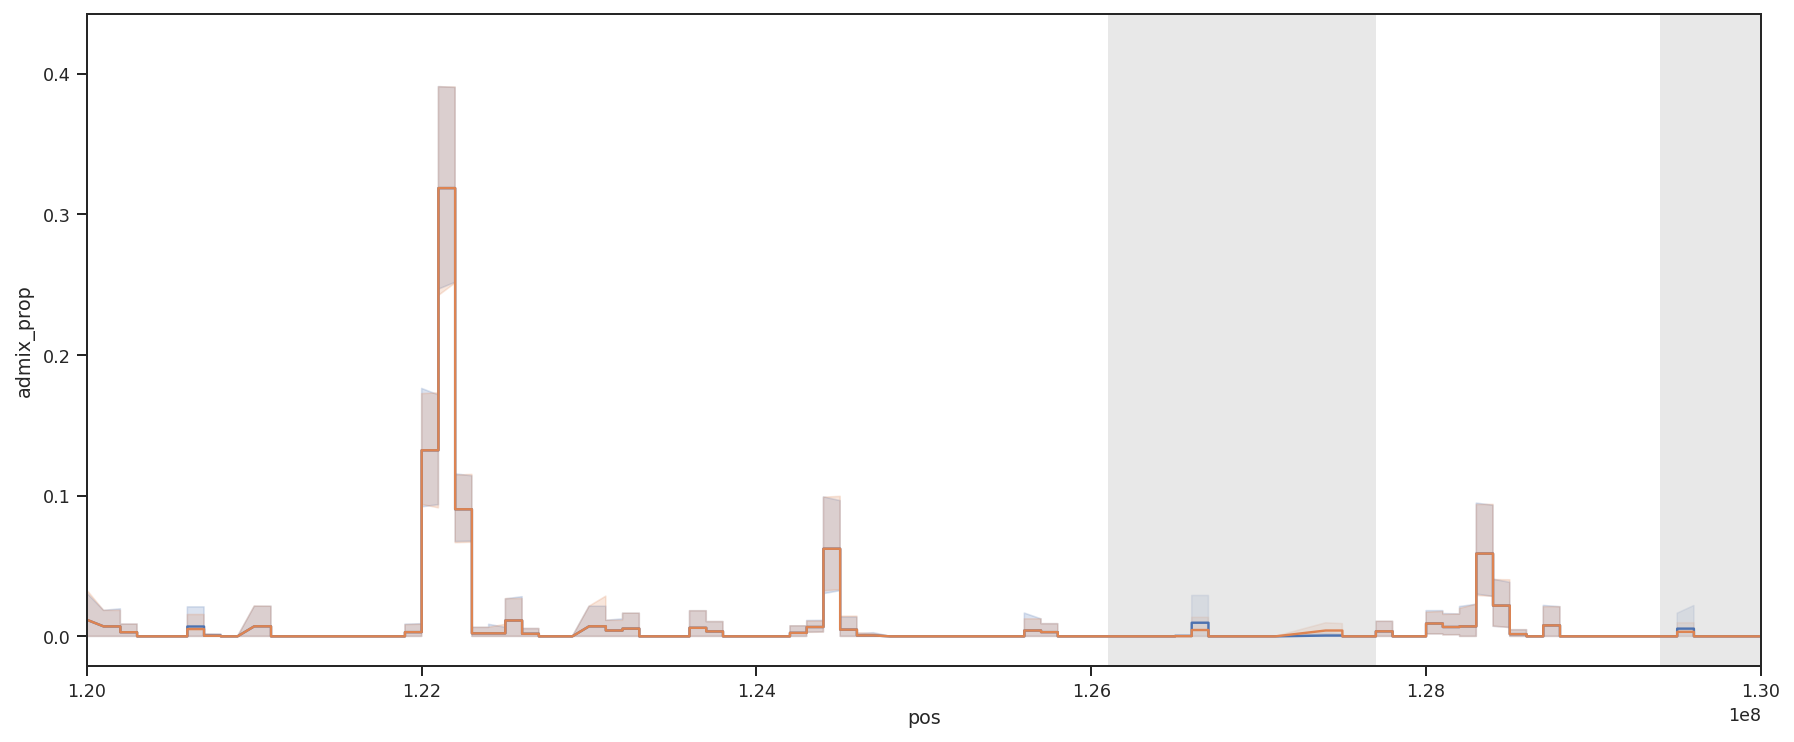

In [140]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(120e6, 130e6)

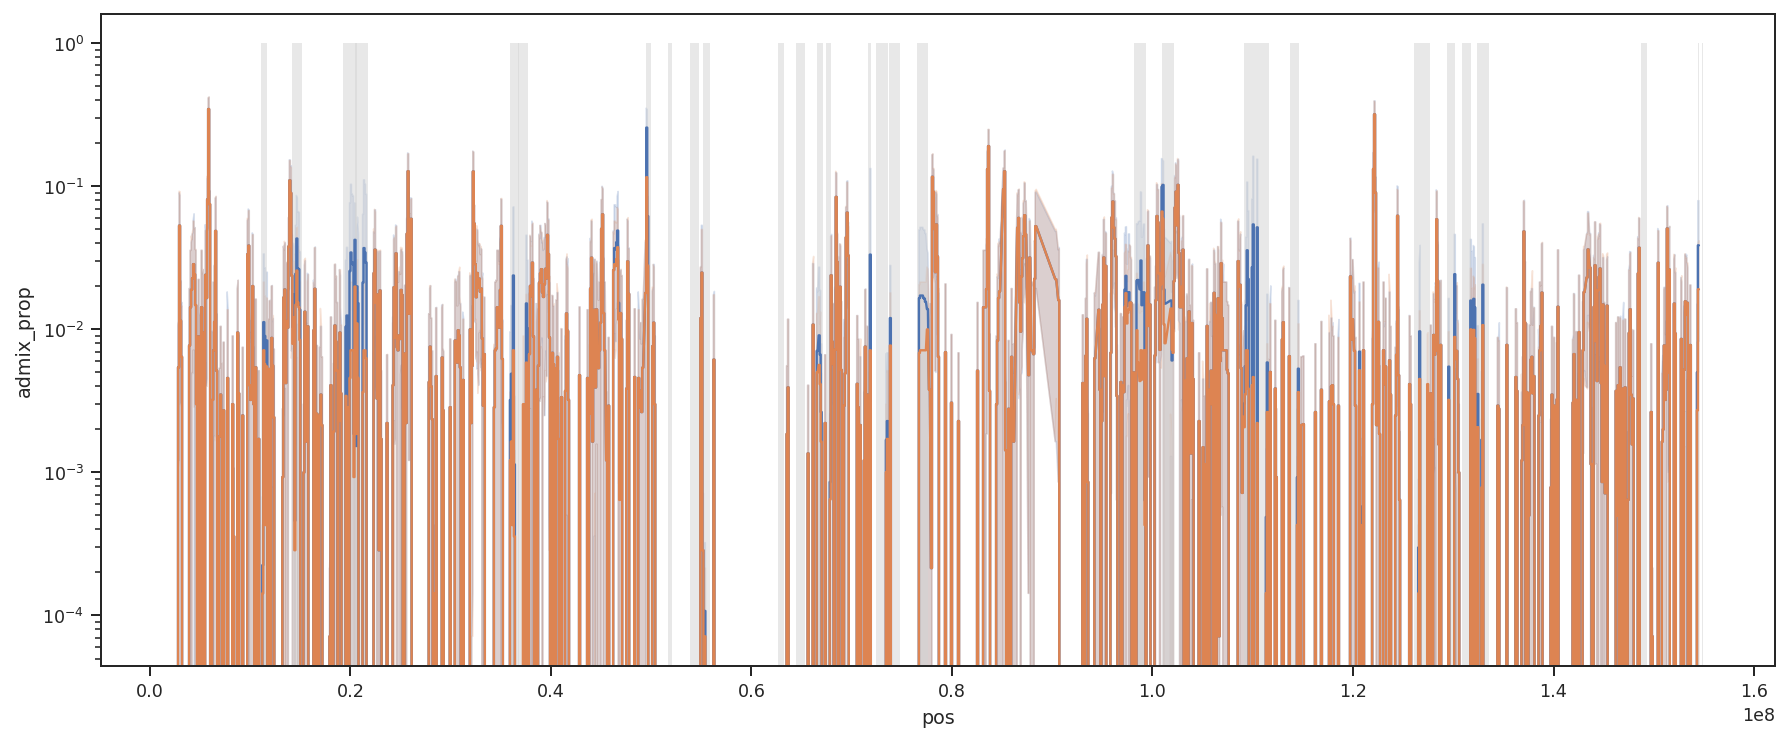

In [141]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_yscale('log')

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])

In [ ]:
# plt.figure(figsize=(20,5))
# #plt.plot(merged_data.start, merged_data.admix_prop)
# filtered = lowess(merged_data.admix_prop, merged_data.start, is_sorted=False, frac=0.001, it=0)
# plt.plot(filtered[:,0], filtered[:,1], color='orange')
# plt.show()